# Challenge 1: Producers Direct (wefarm) dataset
This notebook (`chalenge_1_omar_bensatal.ipynb`) performs a full exploratory data analysis on `datakind_dataset.csv` following the DataKind logging and reproducibility guidelines.

In [ ]:
# 1. Setup & Data Load
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pathlib import Path
from IPython.display import display

plt.style.use('seaborn-v0_8-whitegrid')
DATA_PATH = Path('E://datakind_project//datakind_dataset.csv')
print('Reading:', DATA_PATH)

df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
display(df.head())



Reading: E:\datakind_project\datakind_dataset.csv


"\ndf = pd.read_csv(DATA_PATH)\nprint('Shape:', df.shape)\ndisplay(df.head())\n"

## 2.1 Schema & type snapshot
Quick view of dataframe shape, numeric/object stats, and dtypes.

In [4]:
# 2.1 Schema & type snapshot
print('Dataframe shape:', df.shape)
numeric_desc = df.select_dtypes(include=[np.number]).describe().transpose()
object_desc = df.select_dtypes(include=['object']).describe().transpose()
print('Numeric columns:', len(numeric_desc))
print('Object columns:', len(object_desc))
display(numeric_desc.head(20))
display(object_desc.head(20))
print('Dtypes:')
print(df.dtypes.sort_index())

Dataframe shape: (20304843, 24)
Numeric columns: 4
Object columns: 20
Numeric columns: 4
Object columns: 20
Numeric columns: 4
Object columns: 20


,count,mean,std,min,25%,50%,75%,max
question_id,20304843.0,3.063880e+07,1.635694e+07,3849056.0,16123853.0,29194339.0,45529156.0,59261512.0
question_user_id,20304843.0,1.833289e+06,1.058127e+06,7.0,980110.0,1753870.0,2805610.0,3833007.0
response_id,20304843.0,3.086022e+07,1.636177e+07,3849209.0,16342127.5,29481761.0,45795272.0,59262348.0
response_user_id,20304843.0,1.629548e+06,1.047366e+06,7.0,797065.0,1383485.0,2468823.0,3832167.0


,count,unique,top,freq
question_language,20304843,4,eng,11976781
question_content,20304843,5452290,"S Je Kuna Yule Angeitaji Mikopo Ya Kuku, Bata,...",6269
question_topic,16767114,148,maize,2201755
question_sent,20304843,5862139,2021-05-09 04:42:33.942853+00,2984
response_language,20304843,5,eng,11939866
response_content,20304843,15282991,2,6337
response_topic,6469287,150,maize,586158
response_sent,20304843,16270184,2018-12-17 18:58:00.048992+00,121
question_user_type,20304843,1,farmer,20304843
question_user_status,20304843,4,live,13012402


Dtypes:
question_content              object
question_id                    int64
question_language             object
question_sent                 object
question_topic                object
question_user_country_code    object
question_user_created_at      object
question_user_dob             object
question_user_gender          object
question_user_id               int64
question_user_status          object
question_user_type            object
response_content              object
response_id                    int64
response_language             object
response_sent                 object
response_topic                object
response_user_country_code    object
response_user_created_at      object
response_user_dob             object
response_user_gender          object
response_user_id               int64
response_user_status          object
response_user_type            object
dtype: object


## 2.2 Missing values & null tokens
Count NaNs, blank strings, and explicit null markers per column.

In [5]:
# 2.2 Missing values & null tokens
n_rows = len(df)
missing = df.isna().sum()
missing_pct = (missing / max(n_rows, 1) * 100).round(4)
obj_cols = df.select_dtypes(include='object').columns.tolist()
null_tokens = {'', 'na', 'nan', 'none', 'null'}
empty_counts = {}
null_token_counts = {}
for col in obj_cols:
    col_series = df[col].astype(str)
    empty_counts[col] = int(col_series.str.strip().eq('').sum())
    null_token_counts[col] = int(col_series.str.strip().str.lower().isin(null_tokens).sum())
missing_df = pd.DataFrame({
    'dtype': df.dtypes,
    'missing_count': missing,
    'missing_pct': missing_pct,
    'empty_str_count': [empty_counts.get(c, 0) for c in df.columns],
    'null_token_count': [null_token_counts.get(c, 0) for c in df.columns],
}).sort_values('missing_count', ascending=False)
display(missing_df.head(40))

,dtype,missing_count,missing_pct,empty_str_count,null_token_count
question_user_gender,object,19713950,97.0899,0,19713950
response_user_gender,object,19339833,95.2474,0,19339833
question_user_dob,object,19073559,93.9360,0,19073559
response_user_dob,object,18640155,91.8015,0,18640155
response_topic,object,13835556,68.1392,0,13835556
question_topic,object,3537729,17.4231,0,3537729
question_id,int64,0,0.0000,0,0
question_user_status,object,0,0.0000,0,0
response_user_country_code,object,0,0.0000,0,0
response_user_status,object,0,0.0000,0,0


## 2.3 Duplicate detection without `question_topic`
Surface duplicate rows ignoring topic labels to flag disagreements.

In [6]:
# 2.3 Duplicate detection without question_topic
cols_to_exclude = ['question_topic']
cols_to_check = [c for c in df.columns if c not in cols_to_exclude]
dup_mask = df.duplicated(subset=cols_to_check, keep=False)
duplicates = df.loc[dup_mask].copy()
duplicate_to_drop = df.loc[df.duplicated(subset=cols_to_check, keep='first')]
print(f'Total duplicates (excl question_topic): {len(duplicates):,}')
print(f'Rows to drop if keeping first occurrence: {len(duplicate_to_drop):,}')
display(duplicates.head(20))

Total duplicates (excl question_topic): 5,447,943
Rows to drop if keeping first occurrence: 2,978,928


,question_id,question_user_id,question_language,question_content,question_topic,question_sent,response_id,response_user_id,response_language,response_content,...,question_user_country_code,question_user_gender,question_user_dob,question_user_created_at,response_user_type,response_user_status,response_user_country_code,response_user_gender,response_user_dob,response_user_created_at
2,3849077,307821,nyn,E ENTE YANJE EZAIRE ENYENA YASHOBERA. \nOBWIRE...,cattle,2017-11-22 12:25:08+00,3849291,296187,nyn,Muhanguzi.Benon kuruga masha isingiro ente yaw...,...,ug,NaN,NaN,2017-08-22 14:51:07+00,farmer,zombie,ug,NaN,NaN,2017-08-12 09:30:33+00
3,3849077,307821,nyn,E ENTE YANJE EZAIRE ENYENA YASHOBERA. \nOBWIRE...,cattle,2017-11-22 12:25:08+00,3849291,296187,nyn,Muhanguzi.Benon kuruga masha isingiro ente yaw...,...,ug,NaN,NaN,2017-08-22 14:51:07+00,farmer,zombie,ug,NaN,NaN,2017-08-12 09:30:33+00
4,3849077,307821,nyn,E ENTE YANJE EZAIRE ENYENA YASHOBERA. \nOBWIRE...,cat,2017-11-22 12:25:08+00,3849291,296187,nyn,Muhanguzi.Benon kuruga masha isingiro ente yaw...,...,ug,NaN,NaN,2017-08-22 14:51:07+00,farmer,zombie,ug,NaN,NaN,2017-08-12 09:30:33+00
5,3849077,307821,nyn,E ENTE YANJE EZAIRE ENYENA YASHOBERA. \nOBWIRE...,cat,2017-11-22 12:25:08+00,3849291,296187,nyn,Muhanguzi.Benon kuruga masha isingiro ente yaw...,...,ug,NaN,NaN,2017-08-22 14:51:07+00,farmer,zombie,ug,NaN,NaN,2017-08-12 09:30:33+00
16,3849100,237506,eng,WHERE DO I GET SEEDS OF COCONUT?,pig,2017-11-22 12:25:12+00,4263505,412335,eng,"Q11:try kisumu ,migori ,homa bay,siaya and any...",...,ke,NaN,NaN,2017-06-27 10:45:20+00,farmer,destroyed,ke,NaN,NaN,2017-10-03 17:35:12+00
17,3849100,237506,eng,WHERE DO I GET SEEDS OF COCONUT?,coconut,2017-11-22 12:25:12+00,3852604,412335,eng,Q11:coast Cereals,...,ke,NaN,NaN,2017-06-27 10:45:20+00,farmer,destroyed,ke,NaN,NaN,2017-10-03 17:35:12+00
18,3849100,237506,eng,WHERE DO I GET SEEDS OF COCONUT?,pig,2017-11-22 12:25:12+00,4238099,412335,eng,"Q11:try kisumu ,migori ,homa bay,siaya and any...",...,ke,NaN,NaN,2017-06-27 10:45:20+00,farmer,destroyed,ke,NaN,NaN,2017-10-03 17:35:12+00
19,3849100,237506,eng,WHERE DO I GET SEEDS OF COCONUT?,coconut,2017-11-22 12:25:12+00,4263505,412335,eng,"Q11:try kisumu ,migori ,homa bay,siaya and any...",...,ke,NaN,NaN,2017-06-27 10:45:20+00,farmer,destroyed,ke,NaN,NaN,2017-10-03 17:35:12+00
20,3849100,237506,eng,WHERE DO I GET SEEDS OF COCONUT?,pig,2017-11-22 12:25:12+00,3852604,412335,eng,Q11:coast Cereals,...,ke,NaN,NaN,2017-06-27 10:45:20+00,farmer,destroyed,ke,NaN,NaN,2017-10-03 17:35:12+00
21,3849100,237506,eng,WHERE DO I GET SEEDS OF COCONUT?,coconut,2017-11-22 12:25:12+00,4238099,412335,eng,"Q11:try kisumu ,migori ,homa bay,siaya and any...",...,ke,NaN,NaN,2017-06-27 10:45:20+00,farmer,destroyed,ke,NaN,NaN,2017-10-03 17:35:12+00


## 2.4 Question-topic completeness
Highlight rows where `question_topic` is blank or null-like.

In [7]:
# 2.4 Question-topic completeness filter
rt = 'question_topic'
topic_series = df[rt].astype(str)
topic_mask = topic_series.str.strip().eq('') | topic_series.str.strip().str.lower().isin(null_tokens) | df[rt].isna()
empty_topic = df.loc[topic_mask]
print(f"Empty '{rt}' rows: {len(empty_topic):,} of {len(df):,} ({len(empty_topic)/len(df)*100:.2f}%)")
display(empty_topic.head(50))

Empty 'question_topic' rows: 3,537,729 of 20,304,843 (17.42%)


,question_id,question_user_id,question_language,question_content,question_topic,question_sent,response_id,response_user_id,response_language,response_content,...,question_user_country_code,question_user_gender,question_user_dob,question_user_created_at,response_user_type,response_user_status,response_user_country_code,response_user_gender,response_user_dob,response_user_created_at
0,3849056,519124,nyn,E ABA WEFARM OFFICES ZABO NIZISHANGWA NKAHI?,NaN,2017-11-22 12:25:03+00,20691011,200868,nyn,E!23 Omubazi Ni Dudu Cipa',...,ug,NaN,NaN,2017-11-18 13:09:11+00,farmer,live,ug,NaN,NaN,2017-05-09 09:19:33+00
1,3849061,521327,eng,Q this goes to wefarm. is it possible to get f...,NaN,2017-11-22 12:25:05+00,4334249,526113,eng,Q1 which stage is marleks last vaccinated,...,ug,NaN,NaN,2017-11-20 11:55:48+00,farmer,zombie,ug,NaN,NaN,2017-11-22 10:13:03+00
6,3849078,174909,nyn,E. Radio ezimwagaba nituzituga tunta ariho aba...,NaN,2017-11-22 12:25:09+00,3849334,438108,nyn,E7 MukozeseRadioezahansimu,...,ug,NaN,1992-04-28,2017-04-02 06:16:18+00,farmer,live,ug,NaN,NaN,2017-10-13 09:13:41+00
22,3849117,524698,swa,"Q:niko Na Punda,,anakohoa Ni Dawa Gany Naexa M...",NaN,2017-11-22 12:25:15+00,3852589,506713,swa,Mpe Punda Yako Kitunguu Kwa Maji.,...,ke,NaN,NaN,2017-11-21 17:31:09+00,farmer,live,ke,NaN,NaN,2017-11-13 05:15:24+00
30,3849195,524746,swa,S niko na watu kumi hapa busia kwa sasa wanaul...,NaN,2017-11-22 12:27:18+00,3864261,68583,swa,S182 Busia muko wapi matayos ama namboboto nik...,...,ke,NaN,NaN,2017-11-21 17:33:50+00,farmer,zombie,ke,female,1971-02-02,2016-05-17 05:33:45+00
38,3849225,520739,eng,Q My is found in nandi county,NaN,2017-11-22 12:29:17+00,3849237,334129,eng,Q15yes,...,ke,NaN,NaN,2017-11-20 06:32:15+00,farmer,zombie,ke,NaN,NaN,2017-09-07 04:46:17+00
42,3849249,526417,nyn,E'izina stephen,NaN,2017-11-22 12:31:37+00,43999448,508186,nyn,"E2 KABALE,KAMWENGE,IBANDA CENTRAL MARKET",...,ug,NaN,NaN,2017-11-22 12:30:27+00,farmer,live,ug,NaN,NaN,2017-11-13 16:39:25+00
45,3849276,492364,eng,Where do I find them in MBALE,NaN,2017-11-22 12:33:45+00,3898104,426282,eng,Qn5.find them at agricultural seeds shop near ...,...,ug,NaN,NaN,2017-11-08 18:06:57+00,farmer,zombie,ug,NaN,NaN,2017-10-10 12:22:54+00
46,3849276,492364,eng,Where do I find them in MBALE,NaN,2017-11-22 12:33:45+00,4060711,426282,eng,Qn5.around naboa road,...,ug,NaN,NaN,2017-11-08 18:06:57+00,farmer,zombie,ug,NaN,NaN,2017-10-10 12:22:54+00
59,3849315,500811,eng,Q how can i control army worm in feilds,NaN,2017-11-22 12:37:35+00,3860220,442786,eng,"Q4:by spraying,weeding en prunning",...,ug,NaN,NaN,2017-11-10 08:14:51+00,farmer,zombie,ug,NaN,NaN,2017-10-16 08:31:41+00


## 2.5 Unique topic catalogue
List distinct question/response topics plus missing counts.

In [8]:
# 2.5 Unique topic catalogue
q_series = df['question_topic']
r_series = df['response_topic']
q_unique = sorted({str(x).strip() for x in q_series.dropna() if str(x).strip() not in ('',)})
r_unique = sorted({str(x).strip() for x in r_series.dropna() if str(x).strip() not in ('',)})
print('Question topics (non-empty):', len(q_unique))
print(q_unique)
print('Missing question_topic rows:', int(q_series.isna().sum()))
print('\nResponse topics (non-empty):', len(r_unique))
print(r_unique)
print('Missing response_topic rows:', int(r_series.isna().sum()))

Question topics (non-empty): 148
['acacia', 'african-nightshade', 'amaranth', 'animal', 'apple', 'apricot', 'asparagus', 'aubergine', 'avocado', 'bamboo', 'banana', 'barley', 'bean', 'bee', 'beetroot', 'bird', 'black-nightshade', 'blackberry', 'boma-rhodes', 'brachiaria-grass', 'broccoli', 'butternut-squash', 'cabbage', 'caliandra', 'camel', 'capsicum', 'carrot', 'cashew-nut', 'cassava', 'castor-bean', 'cat', 'cattle', 'cauliflower', 'celery', 'cereal', 'chard', 'chia', 'chicken', 'chickpea', 'chilli', 'clover', 'cocoa', 'coconut', 'coffee', 'collard-greens', 'corriander', 'cotton', 'courgette', 'cowpea', 'cranberry', 'crop', 'cucumber', 'cyprus', 'desmodium', 'dog', 'duck', 'eucalyptus', 'finger-millet', 'fish', 'flax', 'french-bean', 'garlic', 'ginger', 'goat', 'gooseberry', 'grape', 'grass', 'greens', 'guava', 'guinea-fowl', 'guinea-pig', 'jackfruit', 'kale', 'leek', 'lemon', 'lettuce', 'leucaena', 'livestock', 'locust', 'lucern', 'lupin', 'macademia', 'maize', 'mango', 'melon', 'mi

## 2.6 Language column profiling
Value counts for detected language columns on questions and responses.

In [9]:
# 2.6 Language column profiling
lang_cols = [c for c in df.columns if 'lang' in c.lower() or 'language' in c.lower()]
print('Detected language columns:', lang_cols)
for col in lang_cols:
    print(f'Top values for {col}:')
    display(df[col].value_counts(dropna=False).head(20))
q_lang = next((c for c in lang_cols if 'question' in c.lower()), None)
if q_lang:
    print('Question language distribution:')
    display(df[q_lang].value_counts(dropna=False).head(20))

Detected language columns: ['question_language', 'response_language']
Top values for question_language:


question_language
eng    11976781
swa     6480848
nyn     1157228
lug      689986
Name: count, dtype: int64

Top values for response_language:


response_language
eng    11939866
swa     6589074
nyn     1094640
lug      681219
spa          44
Name: count, dtype: int64

Question language distribution:


question_language
eng    11976781
swa     6480848
nyn     1157228
lug      689986
Name: count, dtype: int64

## 2.7 Demographic snapshot
Quick distribution for gender, DOB, and location-style columns.

In [10]:
# 2.7 Demographic snapshot
demo_cols = [c for c in df.columns if any(token in c.lower() for token in ['dob', 'gender', 'country'])]
print('Detected demographic columns:', demo_cols)
for col in demo_cols:
    if df[col].dtype == 'object':
        print(f'Top categories for {col}:')
        display(df[col].value_counts(dropna=False).head(20))
    else:
        print(f'Stat summary for {col}:')
        display(df[col].describe())

Detected demographic columns: ['question_user_country_code', 'question_user_gender', 'question_user_dob', 'response_user_country_code', 'response_user_gender', 'response_user_dob']
Top categories for question_user_country_code:


question_user_country_code
ke    9758607
ug    6312194
tz    4233726
gb        316
Name: count, dtype: int64

Top categories for question_user_gender:


question_user_gender
NaN       19713950
male        464187
female      126706
Name: count, dtype: int64

Top categories for question_user_dob:


question_user_dob
NaN           19073559
1920-06-12       23702
1988-01-19       13017
1991-03-09        9892
1989-08-01        8741
1978-05-25        6160
1996-11-15        6116
1944-11-01        5167
2000-10-05        4642
1988-04-18        4316
1995-03-19        3840
1979-11-19        3699
2001-05-06        3327
1984-07-03        3289
1983-10-18        3235
1968-10-03        2926
1977-07-02        2904
2019-08-01        2718
2018-12-27        2667
2000-10-04        2619
Name: count, dtype: int64

Top categories for response_user_country_code:


response_user_country_code
ke    9769748
ug    6312194
tz    4222579
gb        322
Name: count, dtype: int64

Top categories for response_user_gender:


response_user_gender
NaN       19339833
male        788634
female      176376
Name: count, dtype: int64

Top categories for response_user_dob:


response_user_dob
NaN           18640155
2019-08-28       20477
1957-03-08       13411
1919-02-20        9899
1988-03-16        6887
1976-08-21        6660
1985-10-28        6028
1991-03-09        5518
1986-04-06        5455
2000-10-05        5175
1996-12-10        4524
1982-02-02        4214
1971-01-30        4117
1993-04-05        4087
1977-07-02        3959
1997-10-17        3950
1984-07-14        3919
1920-06-12        3751
1971-11-15        3712
1996-11-29        3587
Name: count, dtype: int64

## 2.8 Datetime parsing & canonical selection
Parse object timestamps into UTC `_dt` fields and pick a primary date.

In [11]:
# Convert to datetime (UTC) and then remove timezone info
df['question_sent_dt'] = pd.to_datetime(df['question_sent'], errors='coerce', utc=True).dt.tz_localize(None)

In [12]:
# Check empty or null rows count in question_sent_dt
total_rows = len(df)
null_count = df['question_sent_dt'].isna().sum()
null_pct = (null_count / total_rows * 100).round(2)

print(f"Total rows: {total_rows:,}")
print(f"Null/NaT in question_sent_dt: {null_count:,} ({null_pct}%)")

# Show value counts to understand the distribution
print("\nValue type distribution:")
print(f"Valid timestamps: {(df['question_sent_dt'].notna()).sum():,}")
print(f"NaT (null) values: {null_count:,}")

Total rows: 20,304,843
Null/NaT in question_sent_dt: 19,964,050 (98.32%)

Value type distribution:
Valid timestamps: 340,793
NaT (null) values: 19,964,050


In [13]:
# Create a comparison table of valid vs invalid timestamps
sample_df = df[['question_sent', 'question_sent_dt']].copy()

# Get 10 valid (non-null) examples
valid_samples = sample_df[sample_df['question_sent_dt'].notna()].head(10)

# Get 10 invalid (null) examples
invalid_samples = sample_df[sample_df['question_sent_dt'].isna()].head(10)

# Combine and label them
valid_samples['status'] = 'VALID'
invalid_samples['status'] = 'INVALID'

comparison_table = pd.concat([valid_samples, invalid_samples], ignore_index=True)

print("Comparison of Valid vs Invalid Timestamps:")
print("=" * 80)
display(comparison_table)

# Also show value counts for better understanding
print("\nSummary:")
print(f"Total valid timestamps: {sample_df['question_sent_dt'].notna().sum():,}")
print(f"Total invalid timestamps: {sample_df['question_sent_dt'].isna().sum():,}")

Comparison of Valid vs Invalid Timestamps:


,question_sent,question_sent_dt,status
0,2017-11-22 12:25:03+00,2017-11-22 12:25:03,VALID
1,2017-11-22 12:25:05+00,2017-11-22 12:25:05,VALID
2,2017-11-22 12:25:08+00,2017-11-22 12:25:08,VALID
3,2017-11-22 12:25:08+00,2017-11-22 12:25:08,VALID
4,2017-11-22 12:25:08+00,2017-11-22 12:25:08,VALID
5,2017-11-22 12:25:08+00,2017-11-22 12:25:08,VALID
6,2017-11-22 12:25:09+00,2017-11-22 12:25:09,VALID
7,2017-11-22 12:25:10+00,2017-11-22 12:25:10,VALID
8,2017-11-22 12:25:10+00,2017-11-22 12:25:10,VALID
9,2017-11-22 12:25:10+00,2017-11-22 12:25:10,VALID



Summary:
Total valid timestamps: 340,793
Total invalid timestamps: 19,964,050


In [14]:
# 1. Clean whitespace (removes accidental spaces before/after)
df['question_sent'] = df['question_sent'].astype(str).str.strip()
df['response_sent'] = df['response_sent'].astype(str).str.strip()
df['question_user_created_at'] = df['question_user_created_at'].astype(str).str.strip()
df['response_user_created_at'] = df['response_user_created_at'].astype(str).str.strip()

In [15]:
# Clean invalid timestamps by removing microseconds after 
df['question_sent'] = df['question_sent'].astype(str).str.replace(r'\.\d+', '', regex=True)
df['response_sent'] = df['response_sent'].astype(str).str.replace(r'\.\d+', '', regex=True)
df['question_user_created_at'] = df['question_user_created_at'].astype(str).str.replace(r'\.\d+', '', regex=True)
df['response_user_created_at'] = df['response_user_created_at'].astype(str).str.replace(r'\.\d+', '', regex=True)

print("Cleaned timestamp formats by removing microseconds")
print("\nSample cleaned timestamps:")
print(df[['question_sent', 'response_sent']].head())

Cleaned timestamp formats by removing microseconds

Sample cleaned timestamps:
            question_sent           response_sent
0  2017-11-22 12:25:03+00  2019-01-24 17:54:06+00
1  2017-11-22 12:25:05+00  2018-01-04 08:57:28+00
2  2017-11-22 12:25:08+00  2017-11-22 12:35:26+00
3  2017-11-22 12:25:08+00  2017-11-22 12:35:26+00
4  2017-11-22 12:25:08+00  2017-11-22 12:35:26+00
            question_sent           response_sent
0  2017-11-22 12:25:03+00  2019-01-24 17:54:06+00
1  2017-11-22 12:25:05+00  2018-01-04 08:57:28+00
2  2017-11-22 12:25:08+00  2017-11-22 12:35:26+00
3  2017-11-22 12:25:08+00  2017-11-22 12:35:26+00
4  2017-11-22 12:25:08+00  2017-11-22 12:35:26+00
            question_sent           response_sent
0  2017-11-22 12:25:03+00  2019-01-24 17:54:06+00
1  2017-11-22 12:25:05+00  2018-01-04 08:57:28+00
2  2017-11-22 12:25:08+00  2017-11-22 12:35:26+00
3  2017-11-22 12:25:08+00  2017-11-22 12:35:26+00
4  2017-11-22 12:25:08+00  2017-11-22 12:35:26+00


In [16]:
# Convert to datetime (UTC) and then remove timezone info
df['question_sent_dt'] = pd.to_datetime(df['question_sent'], errors='coerce', utc=True).dt.tz_localize(None)

In [17]:
# Create a comparison table of valid vs invalid timestamps
sample_df = df[['question_sent', 'question_sent_dt']].copy()

# Get 10 valid (non-null) examples
valid_samples = sample_df[sample_df['question_sent_dt'].notna()].head(10)

# Get 10 invalid (null) examples
invalid_samples = sample_df[sample_df['question_sent_dt'].isna()].head(10)

# Combine and label them
valid_samples['status'] = 'VALID'
invalid_samples['status'] = 'INVALID'

comparison_table = pd.concat([valid_samples, invalid_samples], ignore_index=True)

print("Comparison of Valid vs Invalid Timestamps:")
print("=" * 80)
display(comparison_table)

# Also show value counts for better understanding
print("\nSummary:")
print(f"Total valid timestamps: {sample_df['question_sent_dt'].notna().sum():,}")
print(f"Total invalid timestamps: {sample_df['question_sent_dt'].isna().sum():,}")

Comparison of Valid vs Invalid Timestamps:


,question_sent,question_sent_dt,status
0,2017-11-22 12:25:03+00,2017-11-22 12:25:03,VALID
1,2017-11-22 12:25:05+00,2017-11-22 12:25:05,VALID
2,2017-11-22 12:25:08+00,2017-11-22 12:25:08,VALID
3,2017-11-22 12:25:08+00,2017-11-22 12:25:08,VALID
4,2017-11-22 12:25:08+00,2017-11-22 12:25:08,VALID
5,2017-11-22 12:25:08+00,2017-11-22 12:25:08,VALID
6,2017-11-22 12:25:09+00,2017-11-22 12:25:09,VALID
7,2017-11-22 12:25:10+00,2017-11-22 12:25:10,VALID
8,2017-11-22 12:25:10+00,2017-11-22 12:25:10,VALID
9,2017-11-22 12:25:10+00,2017-11-22 12:25:10,VALID



Summary:
Total valid timestamps: 20,304,843
Total invalid timestamps: 0


In [18]:
# converting all date columns to datetime (will not convert dob since it has too many na's)
date_cols = ['response_sent', # we reconvert it to its original column will remove the other one later
    'question_sent',
    'response_user_created_at',
    'question_user_created_at'
    ]

for col in date_cols: 
    # Convert to datetime
    df[col] = pd.to_datetime(df[col], errors='coerce')
    
    print(f"Finished converting {col}")

Finished converting response_sent
Finished converting question_sent
Finished converting question_sent
Finished converting question_sent
Finished converting response_user_created_at
Finished converting response_user_created_at
Finished converting response_user_created_at
Finished converting question_user_created_at
Finished converting question_user_created_at
Finished converting question_user_created_at


## 2.9 Rows with all required datetimes
Show records where every requested datetime column is populated.

In [19]:
# 2.9 Required datetime row inspection
required_cols = [
    'response_sent',
    'question_sent',
    'response_user_created_at',
    'question_user_created_at'
]
present_cols = [c for c in required_cols if c in df.columns]
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    print('Missing columns skipped:', missing_cols)
if present_cols:
    filtered = df.dropna(subset=present_cols)
    print(f'Rows with all present datetime columns populated: {len(filtered):,}')
    display(filtered.head(30)[present_cols])
else:
    print('None of the requested datetime columns are available.')

Rows with all present datetime columns populated: 20,304,843


,response_sent,question_sent,response_user_created_at,question_user_created_at
0,2019-01-24 17:54:06+00:00,2017-11-22 12:25:03+00:00,2017-05-09 09:19:33+00:00,2017-11-18 13:09:11+00:00
1,2018-01-04 08:57:28+00:00,2017-11-22 12:25:05+00:00,2017-11-22 10:13:03+00:00,2017-11-20 11:55:48+00:00
2,2017-11-22 12:35:26+00:00,2017-11-22 12:25:08+00:00,2017-08-12 09:30:33+00:00,2017-08-22 14:51:07+00:00
3,2017-11-22 12:35:26+00:00,2017-11-22 12:25:08+00:00,2017-08-12 09:30:33+00:00,2017-08-22 14:51:07+00:00
4,2017-11-22 12:35:26+00:00,2017-11-22 12:25:08+00:00,2017-08-12 09:30:33+00:00,2017-08-22 14:51:07+00:00
5,2017-11-22 12:35:26+00:00,2017-11-22 12:25:08+00:00,2017-08-12 09:30:33+00:00,2017-08-22 14:51:07+00:00
6,2017-11-22 12:38:35+00:00,2017-11-22 12:25:09+00:00,2017-10-13 09:13:41+00:00,2017-04-02 06:16:18+00:00
7,2018-05-18 17:42:38+00:00,2017-11-22 12:25:10+00:00,2016-10-11 04:51:10+00:00,2017-10-05 18:17:29+00:00
8,2017-11-22 12:41:32+00:00,2017-11-22 12:25:10+00:00,2017-11-03 10:21:40+00:00,2017-10-05 18:17:29+00:00
9,2017-11-22 15:26:07+00:00,2017-11-22 12:25:10+00:00,2015-11-14 19:59:19+00:00,2015-07-28 17:12:04+00:00


## 2.10 Datetime coverage summary
Report min/max/span per key timestamp field.

In [20]:
# 2.10 Datetime coverage summary
dt_summary_cols = [
    'question_user_created_at',
    'response_user_created_at',
    'question_sent',
    'response_sent',
]
present_dt_cols = [c for c in dt_summary_cols if c in df.columns]
rows = []
for col in present_dt_cols:
    series = pd.to_datetime(df[col], utc=True, errors='coerce')
    valid = series.dropna()
    if valid.empty:
        rows.append({'column': col, 'count_non_null': 0, 'min': pd.NaT, 'max': pd.NaT, 'span_days': np.nan})
    else:
        min_val = valid.min()
        max_val = valid.max()
        span_days = (max_val - min_val).total_seconds() / 86400
        rows.append({
            'column': col,
            'count_non_null': len(valid),
            'min': min_val,
            'max': max_val,
            'span_days': round(span_days, 2),
        })
if rows:
    summary_df = pd.DataFrame(rows).set_index('column')
    display(summary_df)
    all_vals = pd.concat([pd.to_datetime(df[c], utc=True, errors='coerce').dropna() for c in present_dt_cols])
    if not all_vals.empty:
        print('Overall min datetime:', all_vals.min())
        print('Overall max datetime:', all_vals.max())
else:
    print('No datetime columns available for summary.')

,count_non_null,min,max,span_days
column,,,,
question_user_created_at,20304843,2014-11-27 15:06:11+00:00,2022-04-07 08:05:37+00:00,2687.71
response_user_created_at,20304843,2014-11-27 15:06:11+00:00,2022-04-06 04:48:37+00:00,2686.57
question_sent,20304843,2017-11-22 12:25:03+00:00,2022-06-21 14:31:25+00:00,1672.09
response_sent,20304843,2017-11-22 12:28:03+00:00,2022-07-07 14:12:45+00:00,1688.07


Overall min datetime: 2014-11-27 15:06:11+00:00
Overall max datetime: 2022-07-07 14:12:45+00:00
Overall max datetime: 2022-07-07 14:12:45+00:00
Overall max datetime: 2022-07-07 14:12:45+00:00


## 2.11 Temporal frequency trends
Monthly counts for sent questions/responses and user creation events.

C:\Users\POWER COMPUTER\AppData\Local\Temp\ipykernel_13172\3328858800.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  counts = series.dt.to_period('M').value_counts().sort_index()
C:\Users\POWER COMPUTER\AppData\Local\Temp\ipykernel_13172\3328858800.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  counts = series.dt.to_period('M').value_counts().sort_index()
C:\Users\POWER COMPUTER\AppData\Local\Temp\ipykernel_13172\3328858800.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  counts = series.dt.to_period('M').value_counts().sort_index()
C:\Users\POWER COMPUTER\AppData\Local\Temp\ipykernel_13172\3328858800.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  counts = series.dt.to_period('M').value_counts().sort_index()
C:\Users\POWER COMPUTER\AppData\Local\Temp\ipykernel_13172\332885880

Total counts per series:


,total_count
Questions (sent),20304843
Askers created,20304843
Responses (sent),20304843
Responders created,20304843


Top months for Questions (sent):
2018-11-01    1343749
2018-12-01    1169010
2018-09-01     991253
2018-10-01     935994
2018-08-01     935497
Name: Questions (sent), dtype: int64
Top months for Askers created:
2018-08-01    1244067
2018-09-01    1149754
2018-11-01     944993
2018-10-01     943270
2018-07-01     603009
Name: Askers created, dtype: int64
Top months for Responses (sent):
2018-11-01    1343755
2018-12-01    1186755
2018-09-01     980131
2018-10-01     927577
2018-08-01     921191
Name: Responses (sent), dtype: int64
Top months for Responders created:
2018-08-01    1272302
2018-09-01    1095355
2018-10-01     903964
2018-11-01     842666
2017-09-01     683661
Name: Responders created, dtype: int64


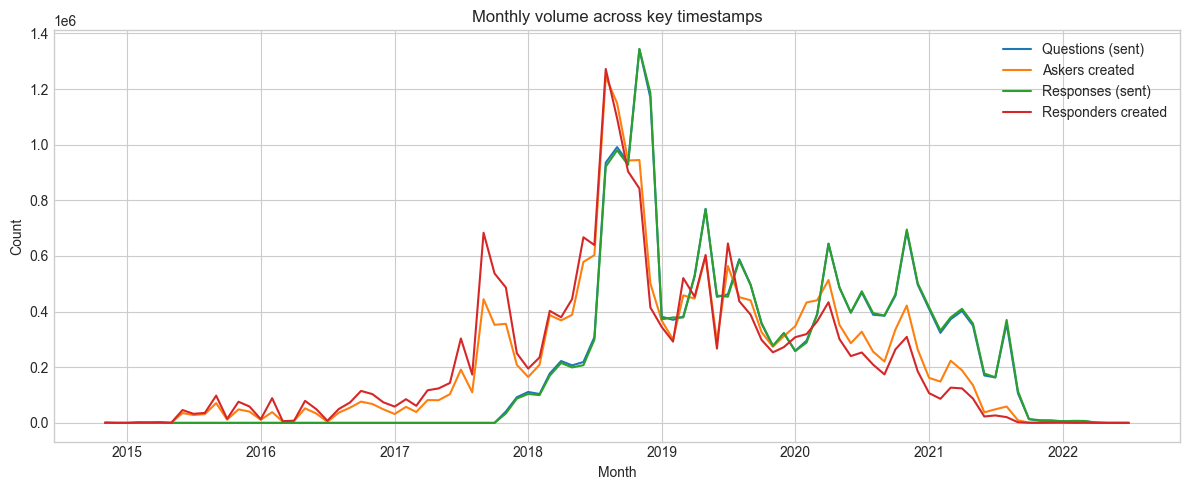

In [21]:
# 2.11 Temporal frequency trends
freq_cols = {
    'question_sent': 'Questions (sent)',
    'question_user_created_at': 'Askers created',
    'response_sent': 'Responses (sent)',
    'response_user_created_at': 'Responders created',
}
present_freq = {col: label for col, label in freq_cols.items() if col in df.columns}
if present_freq:
    monthly = {}
    for col, label in present_freq.items():
        series = pd.to_datetime(df[col], utc=True, errors='coerce').dropna()
        counts = series.dt.to_period('M').value_counts().sort_index()
        counts.index = counts.index.to_timestamp()
        monthly[label] = counts
    monthly_df = pd.DataFrame(monthly).fillna(0).astype(int).sort_index()
    print('Total counts per series:')
    display(monthly_df.sum().to_frame('total_count'))
    for col in monthly_df.columns:
        print(f'Top months for {col}:')
        print(monthly_df[col].nlargest(5))
    plt.figure(figsize=(12, 5))
    for col in monthly_df.columns:
        sns.lineplot(x=monthly_df.index, y=monthly_df[col], label=col)
    plt.title('Monthly volume across key timestamps')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print('No datetime columns available for monthly aggregation.')

## 2.12 Unique IDs per year
First timestamp per ID to count yearly unique questions/responses.

,unique_questions,unique_responses
2017,43009,93148
2018,1523738,5119814
2019,1675921,4341351
2020,1790936,4448623
2021,826220,2262388
2022,5995,17819


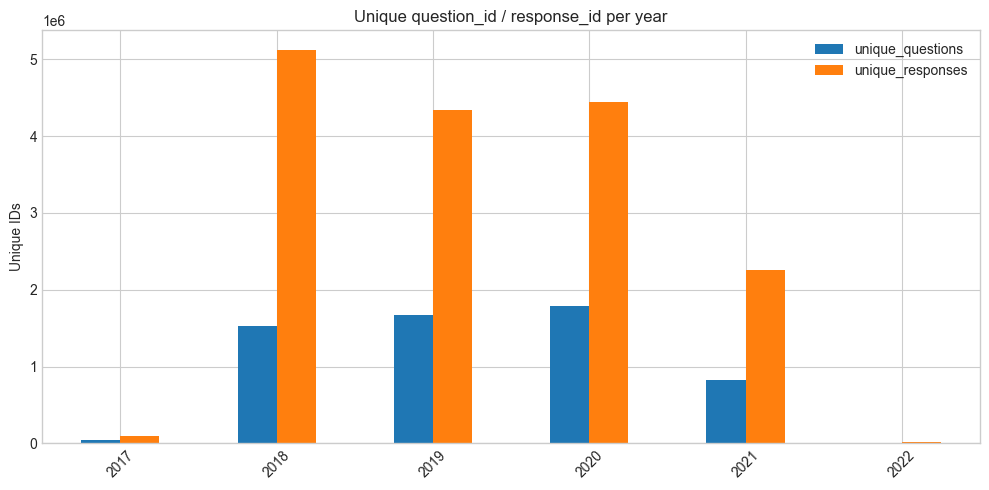

In [22]:
# 2.12 Unique IDs per year
q_dt_col = 'question_sent'
r_dt_col = 'response_sent'
for required in [q_dt_col, r_dt_col]:
    if required not in df.columns:
        print(f"Missing required datetime column: {required}")

def compute_unique_counts(id_col: str, dt_col: str) -> pd.Series:
    if dt_col not in df.columns or id_col not in df.columns:
        return pd.Series(dtype='int64', name=f'unique_{id_col}')
    subset = df[[id_col, dt_col]].dropna(subset=[dt_col])
    if subset.empty:
        return pd.Series(dtype='int64', name=f'unique_{id_col}')
    earliest = subset.sort_values(dt_col).drop_duplicates(id_col, keep='first')
    counts = earliest[dt_col].dt.year.value_counts().sort_index()
    counts.name = f'unique_{id_col}'
    return counts
q_counts = compute_unique_counts('question_id', q_dt_col)
r_counts = compute_unique_counts('response_id', r_dt_col)
if q_counts.empty and r_counts.empty:
    print('Insufficient datetime coverage for unique per year analysis.')
else:
    years = sorted(set(q_counts.index).union(set(r_counts.index)))
    summary = pd.DataFrame(index=years)
    summary['unique_questions'] = q_counts.reindex(years).fillna(0).astype(int)
    summary['unique_responses'] = r_counts.reindex(years).fillna(0).astype(int)
    display(summary)
    ax = summary.plot(kind='bar', figsize=(10, 5))
    ax.set_ylabel('Unique IDs')
    ax.set_title('Unique question_id / response_id per year')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 2.13 Power user identification
Rank top askers/answerers and export CSV for review.

In [26]:
# 2.13 Power user identification
asker_col = 'question_user_id'
answerer_col = 'response_user_id'
question_text_col = 'question_content'
answer_text_col = 'response_content'
missing_cols = [c for c in [asker_col, answerer_col, question_text_col, answer_text_col] if c not in df.columns]
if missing_cols:
    print('Missing required columns for power user analysis:', missing_cols)
else:
    top_n = 20
    top_askers = df[asker_col].value_counts().head(top_n)
    top_answerers = df[answerer_col].value_counts().head(top_n)
    print(f'Top {top_n} askers:')
    display(top_askers)
    print(f'Top {top_n} answerers:')
    display(top_answerers)
    rows = []
    for user, count in top_askers.items():
        rows.append({'user_id': str(user), 'role': 'asker', 'count': int(count)})
    for user, count in top_answerers.items():
        rows.append({'user_id': str(user), 'role': 'answerer', 'count': int(count)})
    out_path = Path('challenge_1/top_power_users.csv')
    out_path.parent.mkdir(parents=True, exist_ok=True)
    pd.DataFrame(rows).to_csv(out_path, index=False)
    print('Saved power user summary to', out_path)

Top 20 askers:


question_user_id
3588962    30399
3373248    27658
730226     23702
3413249    22075
3199006    17990
1061058    13428
853100     12952
1206146    10575
3065420    10494
679197      9832
793767      9486
607370      9381
98211       8726
3561802     8478
2361792     7390
1053962     7317
2855630     7102
2172146     6951
934379      6782
1144761     6262
Name: count, dtype: int64

Top 20 answerers:


response_user_id
810401     25356
3413249    24735
1364605    23151
1049966    20391
1458295    15938
367428     13411
1254217    10630
3065420    10264
202949      9899
1053962     9311
1149700     8675
732878      8508
478338      8444
1019419     8292
1151861     8066
793767      7541
607370      7517
910595      7505
472960      6969
431438      6805
Name: count, dtype: int64

Saved power user summary to challenge_1\top_power_users.csv


## 2.14 Topic popularity overall & by country
Topic value counts overall plus top countries.

In [27]:
# 2.14 Topic popularity overall & by country
topic_cols = [c for c in df.columns if any(token in c.lower() for token in ['topic'])]
print('Topic-like columns:', topic_cols)
if topic_cols:
    topic_col = topic_cols[0]
    print('Top topics overall:')
    display(df[topic_col].value_counts(dropna=False).head(30))
    country_cols = [c for c in df.columns if 'country' in c.lower()]
    country_col = country_cols[0] if country_cols else None
    if country_col:
        top_countries = df[country_col].value_counts().head(5).index.tolist()
        for country in top_countries:
            print('---', country)
            display(df[df[country_col] == country][topic_col].value_counts(dropna=False).head(10))
    else:
        print('No country column available for per-country breakdown.')
else:
    print('No topic-like column detected.')

Topic-like columns: ['question_topic', 'response_topic']
Top topics overall:


question_topic
NaN              3537729
maize            2201755
cattle           1675473
chicken          1667251
tomato           1096386
poultry          1051797
plant            1024498
bean              732120
crop              602913
goat              434284
pig               405320
potato            387830
banana            330052
coffee            286400
animal            266384
rabbit            252086
onion             245854
rice              229105
cabbage           225372
livestock         210497
cotton            180314
sheep             161151
tree              140277
wheat             135199
watermelon        131709
peanut            127392
vegetable         120172
kale              118875
plantain          111130
passion-fruit     104496
Name: count, dtype: int64

--- ke


question_topic
NaN        1224257
cattle     1218676
chicken    1019592
maize      1016368
plant       652196
tomato      439970
poultry     392805
crop        333066
bean        291827
potato      269031
Name: count, dtype: int64

--- ug


question_topic
NaN        1384222
maize       496842
chicken     410347
tomato      372093
plant       333585
cattle      291854
bean        283567
pig         247089
banana      237033
crop        235157
Name: count, dtype: int64

--- tz


question_topic
NaN        929105
maize      688528
poultry    544228
tomato     284292
chicken    237295
cattle     164936
rice       159411
bean       156713
onion       83357
cotton      78826
Name: count, dtype: int64

--- gb


question_topic
NaN          145
plant         31
tomato        31
vegetable     18
chicken       17
maize         17
bean          13
cattle         7
chilli         7
wheat          7
Name: count, dtype: int64

## 2.15 Text length & vocabulary stats
Length distributions and frequent tokens for question/answer text.

Question text char length stats:


count    20000.000000
mean        62.788300
std         35.182865
min          9.000000
25%         40.000000
50%         54.000000
75%         76.000000
max        472.000000
Name: question_content, dtype: float64

Question token count stats:


count    20000.000000
mean        10.451350
std          5.851944
min          1.000000
25%          7.000000
50%          9.000000
75%         13.000000
max         94.000000
Name: question_content, dtype: float64

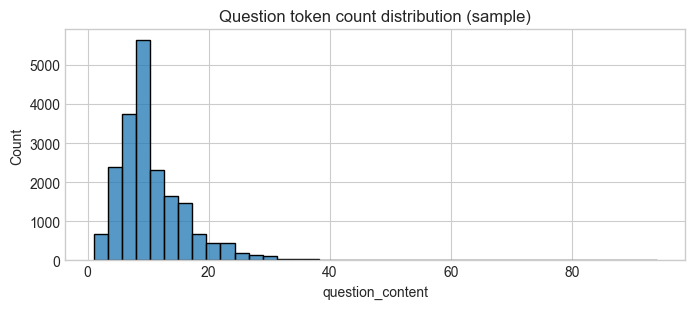

Top 40 tokens in question sample:


[('ya', 2791),
 ('na', 2562),
 ('which', 2170),
 ('plant', 1719),
 ('maize', 1672),
 ('wa', 1538),
 ('ni', 1524),
 ('kuku', 1388),
 ('gani', 1381),
 ('kwa', 1346),
 ('best', 1105),
 ('je', 997),
 ('dawa', 912),
 ('mahindi', 898),
 ('cow', 793),
 ('gan', 625),
 ('use', 605),
 ('beans', 581),
 ('type', 569),
 ('mbegu', 554),
 ('good', 531),
 ('get', 519),
 ('by', 483),
 ('does', 480),
 ('nyanya', 476),
 ('one', 466),
 ('mbolea', 464),
 ('where', 458),
 ('za', 458),
 ('me', 451),
 ('crop', 449),
 ('tomatoes', 448),
 ('many', 447),
 ('kienyeji', 437),
 ('asks', 415),
 ('should', 407),
 ('ili', 403),
 ('long', 393),
 ('want', 391),
 ('planting', 389)]

Answer text char length stats:


count    20000.000000
mean        49.620300
std         51.823083
min          1.000000
25%         18.000000
50%         33.000000
75%         63.000000
max        984.000000
Name: response_content, dtype: float64

Answer token count stats:


count    20000.000000
mean         8.534650
std          8.593451
min          0.000000
25%          3.000000
50%          6.000000
75%         11.000000
max        171.000000
Name: response_content, dtype: float64

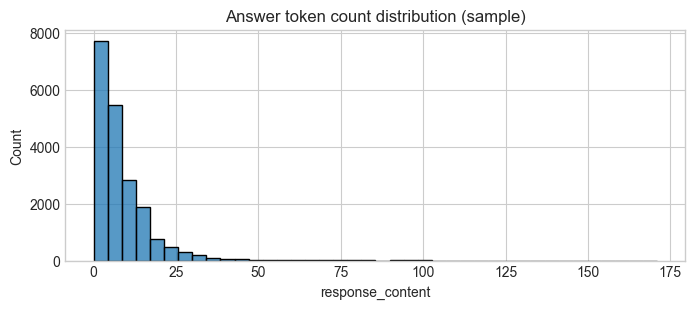

Top 40 tokens in answer sample:


[('na', 2222),
 ('ya', 1976),
 ('kwa', 1063),
 ('ni', 981),
 ('wa', 862),
 ('plant', 808),
 ('by', 794),
 ('maize', 624),
 ('use', 620),
 ('kuku', 558),
 ('dawa', 516),
 ('them', 505),
 ('kama', 492),
 ('yes', 490),
 ('soil', 450),
 ('no', 420),
 ('water', 380),
 ('at', 373),
 ('au', 367),
 ('then', 357),
 ('mbolea', 351),
 ('mbegu', 340),
 ('crops', 336),
 ('beans', 335),
 ('za', 324),
 ('one', 310),
 ('mahindi', 291),
 ('tumia', 291),
 ('its', 275),
 ('which', 273),
 ('as', 257),
 ('cow', 254),
 ('after', 253),
 ('good', 245),
 ('will', 242),
 ('aina', 241),
 ('crop', 229),
 ('give', 228),
 ('like', 226),
 ('moja', 224)]

In [28]:
# 2.15 Text length & vocabulary stats
from collections import Counter
stopwords = {'to','can','be','do','my','is','it','of','on','or','in','the','and','for','that','this','with','are','was','you','we','your','have','not','but','from','they','their','when','how','what'}

def simple_tokenize(text: str) -> list:
    if not isinstance(text, str):
        return []
    cleaned = re.sub(r'[^a-z0-9\s]', ' ', text.lower())
    return [tok for tok in cleaned.split() if len(tok) > 1]

samples = {}
if question_text_col in df.columns:
    sample_q = df[question_text_col].dropna().astype(str).sample(min(20000, max(1000, int(len(df)*0.01))), random_state=42)
    samples['question'] = sample_q
if answer_text_col in df.columns:
    sample_a = df[answer_text_col].dropna().astype(str).sample(min(20000, max(1000, int(len(df)*0.01))), random_state=42)
    samples['answer'] = sample_a
for key, sample in samples.items():
    char_len = sample.str.len()
    token_counts = sample.map(lambda s: len(simple_tokenize(s)))
    print(f'{key.title()} text char length stats:')
    display(char_len.describe())
    print(f'{key.title()} token count stats:')
    display(token_counts.describe())
    plt.figure(figsize=(8, 3))
    sns.histplot(token_counts.clip(upper=400 if key == 'answer' else 200), bins=40)
    plt.title(f'{key.title()} token count distribution (sample)')
    plt.show()
    counter = Counter()
    for text in sample:
        counter.update([tok for tok in simple_tokenize(text) if tok not in stopwords])
    print(f'Top 40 tokens in {key} sample:')
    display(counter.most_common(40))
if not samples:
    print('Could not locate question/response text columns for length analysis.')

## 2.16 Process logging snapshot
Append this EDA run to the shared process log via helper.

In [31]:
# 2.16 Process logging snapshot

manual_drop = ['response_user_dob', 'question_user_dob', 'response_user_gender', 'question_user_gender','question_user_status','response_user_status', 
               'question_user_type', 'response_user_type','question_sent_dt','response_user_created_at','question_user_created_at']
clean_df = df.drop(columns=manual_drop, axis=1)
clean_path = Path('E://datakind_project//datakind_dataset_cleaned.csv')
#clean_df.to_csv(clean_path, index=False) # this was used to save a file localy
print('Saved cleaned dataset to', clean_path)

Saved cleaned dataset to E:\datakind_project\datakind_dataset_cleaned.csv


In [32]:
clean_df.head()

,question_id,question_user_id,question_language,question_content,question_topic,question_sent,response_id,response_user_id,response_language,response_content,response_topic,response_sent,question_user_country_code,response_user_country_code
0,3849056,519124,nyn,E ABA WEFARM OFFICES ZABO NIZISHANGWA NKAHI?,NaN,2017-11-22 12:25:03+00:00,20691011,200868,nyn,E!23 Omubazi Ni Dudu Cipa',NaN,2019-01-24 17:54:06+00:00,ug,ug
1,3849061,521327,eng,Q this goes to wefarm. is it possible to get f...,NaN,2017-11-22 12:25:05+00:00,4334249,526113,eng,Q1 which stage is marleks last vaccinated,NaN,2018-01-04 08:57:28+00:00,ug,ug
2,3849077,307821,nyn,E ENTE YANJE EZAIRE ENYENA YASHOBERA. \nOBWIRE...,cattle,2017-11-22 12:25:08+00:00,3849291,296187,nyn,Muhanguzi.Benon kuruga masha isingiro ente yaw...,tomato,2017-11-22 12:35:26+00:00,ug,ug
3,3849077,307821,nyn,E ENTE YANJE EZAIRE ENYENA YASHOBERA. \nOBWIRE...,cattle,2017-11-22 12:25:08+00:00,3849291,296187,nyn,Muhanguzi.Benon kuruga masha isingiro ente yaw...,cattle,2017-11-22 12:35:26+00:00,ug,ug
4,3849077,307821,nyn,E ENTE YANJE EZAIRE ENYENA YASHOBERA. \nOBWIRE...,cat,2017-11-22 12:25:08+00:00,3849291,296187,nyn,Muhanguzi.Benon kuruga masha isingiro ente yaw...,tomato,2017-11-22 12:35:26+00:00,ug,ug


In [3]:
# 3A. Fill missing/blank question_topic values
clean_df = pd.read_csv('E://datakind_project//datakind_dataset_cleaned.csv') # this was used to keep this section seperat from the above one
if 'question_topic' not in clean_df.columns:
    raise KeyError('Column `question_topic` is missing from clean_df.')
topic_series = clean_df['question_topic']
blank_mask = topic_series.astype(str).str.strip().eq('')
blank_count = int(blank_mask.sum())
nan_count = int(topic_series.isna().sum())
clean_df.loc[blank_mask, 'question_topic'] = np.nan
clean_df['question_topic'] = clean_df['question_topic'].fillna('other')
print(f"Filled {(blank_count + nan_count):,} question_topic rows with 'other' (blanks: {blank_count:,}, NaN: {nan_count:,}).")

Filled 3,537,729 question_topic rows with 'other' (blanks: 0, NaN: 3,537,729).


In [4]:
clean_df.shape

(20304843, 14)

## 19. Weather Data Intake & Daily Aggregation
Load Kenya, Tanzania (daily station feeds), and Uganda (monthly aggregates) weather files, then collapse the station-level daily data to per-day averages to reduce missingness before any cross-country comparisons.

### 19.1 Configure weather paths and validate availability

In [4]:
# 19.1 Configure weather paths
from pathlib import Path

WEATHER_DIR = Path('E://datakind_project')
KENYA_PATH = WEATHER_DIR / 'kenya.csv'
TANZANIA_PATH = WEATHER_DIR / 'tanzania.csv'
UGANDA_PATH = WEATHER_DIR / 'uganda_monthly_1950-2023.xlsx'

print('Weather directory:', WEATHER_DIR)
missing_files = [path for path in (KENYA_PATH, TANZANIA_PATH, UGANDA_PATH) if not path.exists()]
if missing_files:
    missing_str = '\n'.join(str(p) for p in missing_files)
    raise FileNotFoundError(f'Missing weather files:\n{missing_str}')
print('All required weather files found.')

Weather directory: E:\datakind_project
All required weather files found.


### 19.2 Define helper functions (load + daily aggregation)

In [5]:
# 19.2 Helper functions
def load_weather_csv(path: Path, country: str) -> pd.DataFrame:
    df_local = pd.read_csv(path)
    print(f"Loaded {country} daily feed: {len(df_local):,} rows, {df_local.shape[1]} columns")
    return df_local

def aggregate_daily(df_local: pd.DataFrame, country: str) -> pd.DataFrame:
    date_cols = [c for c in df_local.columns if 'date' in c.lower()]
    if not date_cols:
        raise ValueError(f'No date-like column found for {country}.')
    date_col = date_cols[0]
    df_local = df_local.copy()
    df_local[date_col] = pd.to_datetime(df_local[date_col], errors='coerce')
    numeric_cols = df_local.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise ValueError(f'No numeric columns available for averaging in {country}.')
    daily = (
        df_local.dropna(subset=[date_col])
        .groupby(date_col)[numeric_cols]
        .mean()
        .reset_index()
        .sort_values(date_col)
    )
    daily['country'] = country
    print(
        f"{country}: {len(daily):,} daily points after averaging {len(numeric_cols)} numeric feature(s) across stations."
    )
    return daily

### 19.3 Load raw weather feeds

In [6]:
# 19.3 Load raw weather feeds
kenya_raw = load_weather_csv(KENYA_PATH, 'Kenya')
tanzania_raw = load_weather_csv(TANZANIA_PATH, 'Tanzania')

Loaded Kenya daily feed: 20,967 rows, 8 columns
Loaded Tanzania daily feed: 20,330 rows, 8 columns


### 19.4 Collapse station readings to per-day averages

In [7]:
# 19.4 Aggregate to daily values
kenya_daily = aggregate_daily(kenya_raw, 'Kenya')
tanzania_daily = aggregate_daily(tanzania_raw, 'Tanzania')

Kenya: 2,920 daily points after averaging 5 numeric feature(s) across stations.
Tanzania: 2,915 daily points after averaging 5 numeric feature(s) across stations.
Tanzania: 2,915 daily points after averaging 5 numeric feature(s) across stations.


### 19.5 Preview the harmonized datasets

### 19.6 Inspect schema / dtypes

In [8]:
# 19.6 DataFrame info snapshots
print('Kenya daily info:')
kenya_info = kenya_daily.info()
print('\nTanzania daily info:')
tanzania_info = tanzania_daily.info()

Kenya daily info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   DATE     2920 non-null   datetime64[ns]
 1   PRCP     2201 non-null   float64       
 2   SNWD     2 non-null      float64       
 3   TAVG     2920 non-null   float64       
 4   TMAX     1419 non-null   float64       
 5   TMIN     2887 non-null   float64       
 6   country  2920 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 159.8+ KB

Tanzania daily info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915 entries, 0 to 2914
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   DATE     2915 non-null   datetime64[ns]
 1   PRCP     2353 non-null   float64       
 2   SNWD     2 non-null      float64       
 3   TAVG     2915 non-null   float64       


In [9]:
# 19.5 Preview dataframes
print('\nKenya daily preview:')
display(kenya_daily.head())
print('\nTanzania daily preview:')
display(tanzania_daily.head())


Kenya daily preview:


,DATE,PRCP,SNWD,TAVG,TMAX,TMIN,country
0,2016-01-01,NaN,NaN,80.000000,91.000000,68.000000,Kenya
1,2016-01-02,NaN,NaN,77.000000,NaN,68.000000,Kenya
2,2016-01-03,0.00,NaN,74.333333,85.333333,63.666667,Kenya
3,2016-01-04,0.08,NaN,79.666667,97.000000,76.500000,Kenya
4,2016-01-05,0.08,NaN,80.750000,97.000000,69.666667,Kenya



Tanzania daily preview:


,DATE,PRCP,SNWD,TAVG,TMAX,TMIN,country
0,2016-01-01,0.513333,NaN,78.000000,88.000000,66.666667,Tanzania
1,2016-01-02,0.040000,NaN,79.428571,89.600000,70.000000,Tanzania
2,2016-01-03,0.462500,NaN,80.285714,88.833333,69.500000,Tanzania
3,2016-01-04,0.040000,NaN,79.857143,87.857143,70.500000,Tanzania
4,2016-01-05,0.126000,NaN,79.285714,88.285714,67.666667,Tanzania


In [10]:
# 19.7 Fill missing TMAX/TMIN using TAVG relationship
def fill_temp_extremes(daily_df: pd.DataFrame, country: str) -> pd.DataFrame:
    """
    Fill missing TMAX/TMIN values using TAVG = (TMAX + TMIN) / 2
    when only one extreme is missing.
    """
    df_filled = daily_df.copy()
    
    # Case 1: TMAX missing but TMIN and TAVG present
    mask_tmax = df_filled['TMAX'].isna() & df_filled['TMIN'].notna() & df_filled['TAVG'].notna()
    if mask_tmax.any():
        df_filled.loc[mask_tmax, 'TMAX'] = 2 * df_filled.loc[mask_tmax, 'TAVG'] - df_filled.loc[mask_tmax, 'TMIN']
        tmax_filled = mask_tmax.sum()
        print(f"{country}: Filled {tmax_filled:,} TMAX values using TAVG and TMIN")
    
    # Case 2: TMIN missing but TMAX and TAVG present
    mask_tmin = df_filled['TMIN'].isna() & df_filled['TMAX'].notna() & df_filled['TAVG'].notna()
    if mask_tmin.any():
        df_filled.loc[mask_tmin, 'TMIN'] = 2 * df_filled.loc[mask_tmin, 'TAVG'] - df_filled.loc[mask_tmin, 'TMAX']
        tmin_filled = mask_tmin.sum()
        print(f"{country}: Filled {tmin_filled:,} TMIN values using TAVG and TMAX")
    
    return df_filled

# Apply filling to both countries
kenya_daily_filled = fill_temp_extremes(kenya_daily, 'Kenya')
tanzania_daily_filled = fill_temp_extremes(tanzania_daily, 'Tanzania')

# Report coverage improvement
print('\nCoverage after filling:')
for df, country in [(kenya_daily_filled, 'Kenya'), (tanzania_daily_filled, 'Tanzania')]:
    tmax_missing = df['TMAX'].isna().sum()
    tmin_missing = df['TMIN'].isna().sum()
    print(f"{country}: TMAX missing = {tmax_missing:,}, TMIN missing = {tmin_missing:,}")

# Update the daily dataframes
kenya_daily = kenya_daily_filled
tanzania_daily = tanzania_daily_filled

print('\nPreview Kenya with filled temperatures:')
display(kenya_daily[['DATE', 'TAVG', 'TMAX', 'TMIN']].head(10))

Kenya: Filled 1,478 TMAX values using TAVG and TMIN
Kenya: Filled 10 TMIN values using TAVG and TMAX
Tanzania: Filled 188 TMAX values using TAVG and TMIN
Tanzania: Filled 75 TMIN values using TAVG and TMAX

Coverage after filling:
Kenya: TMAX missing = 23, TMIN missing = 23
Tanzania: TMAX missing = 17, TMIN missing = 17

Preview Kenya with filled temperatures:
Kenya: Filled 10 TMIN values using TAVG and TMAX
Tanzania: Filled 188 TMAX values using TAVG and TMIN
Tanzania: Filled 75 TMIN values using TAVG and TMAX

Coverage after filling:
Kenya: TMAX missing = 23, TMIN missing = 23
Tanzania: TMAX missing = 17, TMIN missing = 17

Preview Kenya with filled temperatures:


,DATE,TAVG,TMAX,TMIN
0,2016-01-01,80.000000,91.000000,68.000000
1,2016-01-02,77.000000,86.000000,68.000000
2,2016-01-03,74.333333,85.333333,63.666667
3,2016-01-04,79.666667,97.000000,76.500000
4,2016-01-05,80.750000,97.000000,69.666667
5,2016-01-06,76.000000,84.500000,67.500000
6,2016-01-07,79.333333,100.666667,58.000000
7,2016-01-08,81.500000,91.000000,72.333333
8,2016-01-09,80.750000,94.000000,67.500000
9,2016-01-10,80.500000,90.333333,74.000000


## 20. Weather Feature Engineering Roadmap
Introduce coverage diagnostics, rolling aggregations, and lightweight imputations so Kenya/Tanzania weather signals stay robust when merged with agronomic outcomes.

### 20.0 Execution notes
Run the cells in this section sequentially (20.1 â†’ 20.3) so derived features reuse previously computed objects without forcing earlier notebook steps to re-run.

### 20.1 Coverage diagnostics (station counts per day)

In [11]:
# 20.1 Coverage diagnostics
def station_count_by_date(df_raw: pd.DataFrame, country: str) -> pd.DataFrame:
    date_cols = [c for c in df_raw.columns if 'date' in c.lower()]
    if not date_cols:
        raise ValueError(f'No date-like column found for {country} coverage check.')
    date_col = date_cols[0]
    station_cols = [c for c in df_raw.columns if 'station' in c.lower() or 'site' in c.lower()]
    if station_cols:
        station_col = station_cols[0]
        station_series = df_raw[station_col].astype(str).fillna('unknown')
    else:
        station_col = None
        station_series = pd.Series('unknown', index=df_raw.index)
        print(f'Warning: {country} raw data lacks explicit station column; treating each row as one station reading.')
    counts = (
        pd.DataFrame({
            'date': pd.to_datetime(df_raw[date_col], errors='coerce'),
            'station_id': station_series,
        })
        .dropna(subset=['date'])
        .groupby('date')['station_id']
        .nunique()
        .reset_index(name='station_count')
        .sort_values('date')
    )
    counts['country'] = country
    return counts

kenya_station_counts = station_count_by_date(kenya_raw, 'Kenya')
tanzania_station_counts = station_count_by_date(tanzania_raw, 'Tanzania')
coverage_df = pd.concat([kenya_station_counts, tanzania_station_counts], ignore_index=True)

for country, group in coverage_df.groupby('country'):
    summary = group['station_count'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    low_coverage = (group['station_count'] <= group['station_count'].median() / 2).mean() * 100
    print(f"\n{country} station-count summary:")
    display(summary.to_frame(name='value'))
    print(f"Days at <=50% of median station coverage: {low_coverage:.1f}%")


Kenya station-count summary:


,value
count,2920.000000
mean,7.180479
std,1.794312
min,1.000000
10%,5.000000
25%,6.000000
50%,7.000000
75%,9.000000
90%,10.000000
max,10.000000


Days at <=50% of median station coverage: 1.9%

Tanzania station-count summary:


,value
count,2915.000000
mean,6.974271
std,0.266572
min,2.000000
10%,7.000000
25%,7.000000
50%,7.000000
75%,7.000000
90%,7.000000
max,7.000000


Days at <=50% of median station coverage: 0.3%


### 20.2 Rolling aggregates + short-gap imputation

In [12]:
# 20.2 Rolling aggregates + short-gap imputation
ROLL_WINDOWS = (7, 30)
PRECIP_KEYWORDS = ('rain', 'precip', 'prcp')
TEMP_KEYWORDS = ('temp', 'tavg', 'tmean', 'tmax', 'tmin')

def engineer_weather_features(daily_df: pd.DataFrame, country: str) -> pd.DataFrame:
    if daily_df.empty:
        raise ValueError(f'{country} daily dataframe is empty.')
    date_col = next((c for c in daily_df.columns if 'date' in c.lower()), None)
    if date_col is None:
        raise ValueError(f'No date-like column detected for {country} feature engineering.')
    feature_df = daily_df.copy().sort_values(date_col)
    feature_df[date_col] = pd.to_datetime(feature_df[date_col], errors='coerce')
    feature_df = feature_df.dropna(subset=[date_col]).reset_index(drop=True)
    feature_df = feature_df.set_index(date_col)
    numeric_cols = feature_df.select_dtypes(include=[np.number]).columns.tolist()
    precip_cols = [c for c in numeric_cols if any(key in c.lower() for key in PRECIP_KEYWORDS)]
    temp_cols = [c for c in numeric_cols if any(key in c.lower() for key in TEMP_KEYWORDS)]
    if not precip_cols and not temp_cols:
        print(f'Warning: no precip/temp columns matched for {country}. Returning original frame.')
        return feature_df.reset_index()
    fill_report = {}
    def fill_short_gaps(series: pd.Series, window: int = 7) -> pd.Series:
        rolling_mean = series.rolling(window=window, min_periods=1).mean()
        filled = series.fillna(rolling_mean)
        return filled
    for col in precip_cols:
        filled_col = fill_short_gaps(feature_df[col])
        feature_df[f'{col}_filled'] = filled_col
        fill_report[col] = int(filled_col.isna().sum())
        for window in ROLL_WINDOWS:
            feature_df[f'{col}_roll{window}d_sum'] = filled_col.rolling(window=window, min_periods=1).sum()
    for col in temp_cols:
        filled_col = fill_short_gaps(feature_df[col])
        feature_df[f'{col}_filled'] = filled_col
        fill_report[col] = int(filled_col.isna().sum())
        for window in ROLL_WINDOWS:
            feature_df[f'{col}_roll{window}d_mean'] = filled_col.rolling(window=window, min_periods=1).mean()
    feature_df = feature_df.reset_index().rename(columns={'index': date_col})
    feature_df['country'] = country
    if fill_report:
        print(f"{country} columns remaining NaNs after rolling-fill:")
        for col_name, remaining in fill_report.items():
            print(f'  {col_name}: {remaining:,} NaNs')
    return feature_df

kenya_features = engineer_weather_features(kenya_daily, 'Kenya')
tanzania_features = engineer_weather_features(tanzania_daily, 'Tanzania')
print('Feature engineering complete. Preview Kenya enriched features:')
display(kenya_features.head())

Kenya columns remaining NaNs after rolling-fill:
  PRCP: 175 NaNs
  TAVG: 0 NaNs
  TMAX: 2 NaNs
  TMIN: 2 NaNs
Tanzania columns remaining NaNs after rolling-fill:
  PRCP: 56 NaNs
  TAVG: 0 NaNs
  TMAX: 0 NaNs
  TMIN: 0 NaNs
Feature engineering complete. Preview Kenya enriched features:
Tanzania columns remaining NaNs after rolling-fill:
  PRCP: 56 NaNs
  TAVG: 0 NaNs
  TMAX: 0 NaNs
  TMIN: 0 NaNs
Feature engineering complete. Preview Kenya enriched features:


,DATE,PRCP,SNWD,TAVG,TMAX,TMIN,country,PRCP_filled,PRCP_roll7d_sum,PRCP_roll30d_sum,TAVG_filled,TAVG_roll7d_mean,TAVG_roll30d_mean,TMAX_filled,TMAX_roll7d_mean,TMAX_roll30d_mean,TMIN_filled,TMIN_roll7d_mean,TMIN_roll30d_mean
0,2016-01-01,NaN,NaN,80.000000,91.000000,68.000000,Kenya,NaN,NaN,NaN,80.000000,80.000000,80.000000,91.000000,91.000000,91.000000,68.000000,68.000000,68.000000
1,2016-01-02,NaN,NaN,77.000000,86.000000,68.000000,Kenya,NaN,NaN,NaN,77.000000,78.500000,78.500000,86.000000,88.500000,88.500000,68.000000,68.000000,68.000000
2,2016-01-03,0.00,NaN,74.333333,85.333333,63.666667,Kenya,0.00,0.00,0.00,74.333333,77.111111,77.111111,85.333333,87.444444,87.444444,63.666667,66.555556,66.555556
3,2016-01-04,0.08,NaN,79.666667,97.000000,76.500000,Kenya,0.08,0.08,0.08,79.666667,77.750000,77.750000,97.000000,89.833333,89.833333,76.500000,69.041667,69.041667
4,2016-01-05,0.08,NaN,80.750000,97.000000,69.666667,Kenya,0.08,0.16,0.16,80.750000,78.350000,78.350000,97.000000,91.266667,91.266667,69.666667,69.166667,69.166667


### 20.3 Quick diagnostics on engineered features

In [13]:
# 20.3 Diagnostics
def summarize_feature_block(df_features: pd.DataFrame, country: str):
    roll_cols = [c for c in df_features.columns if 'roll' in c]
    if not roll_cols:
        print(f'No rolling columns found for {country}.')
        return
    summary_rows = []
    for col in roll_cols:
        series = df_features[col]
        summary_rows.append({
            'feature': col,
            'min': series.min(),
            'max': series.max(),
            'mean': series.mean(),
            'missing_pct': series.isna().mean() * 100,
        })
    summary_df = pd.DataFrame(summary_rows).sort_values('feature')
    print(f"\n{country} rolling feature stats:")
    display(summary_df.head(20))
    print('... total rolling columns:', len(summary_df))

summarize_feature_block(kenya_features, 'Kenya')
summarize_feature_block(tanzania_features, 'Tanzania')


Kenya rolling feature stats:


,feature,min,max,mean,missing_pct
1,PRCP_roll30d_sum,0.000000,16.808000,5.242720,0.068493
0,PRCP_roll7d_sum,0.000000,7.168333,1.254330,2.260274
3,TAVG_roll30d_mean,70.814444,80.238333,75.225576,0.000000
2,TAVG_roll7d_mean,64.071429,82.311905,75.221299,0.000000
5,TMAX_roll30d_mean,75.613889,95.131667,86.289053,0.000000
4,TMAX_roll7d_mean,72.154762,99.224490,86.246595,0.000000
7,TMIN_roll30d_mean,60.213889,70.922474,66.108283,0.000000
6,TMIN_roll7d_mean,58.023810,72.306803,66.111302,0.000000


... total rolling columns: 8

Tanzania rolling feature stats:


,feature,min,max,mean,missing_pct
1,PRCP_roll30d_sum,0.053333,21.694444,8.175817,0.000000
0,PRCP_roll7d_sum,0.000000,11.922278,1.921804,0.171527
3,TAVG_roll30d_mean,71.347619,79.979365,75.989061,0.000000
2,TAVG_roll7d_mean,70.530612,81.408163,75.988742,0.000000
5,TMAX_roll30d_mean,81.820622,90.381217,86.032639,0.000000
4,TMAX_roll7d_mean,80.341837,91.317007,86.030298,0.000000
7,TMIN_roll30d_mean,59.630794,72.114683,66.882191,0.000000
6,TMIN_roll7d_mean,58.154422,75.571429,66.896536,0.000000


... total rolling columns: 8


## 21. Merge Weather Features With Question Records
Join the engineered Kenya/Tanzania weather features back to `clean_df` (filtered to KE/TZ) so downstream topic or outcome models can incorporate rolling rainfall/temperature context.

### 21.0 Execution notes
1. Filter `clean_df` to KE/TZ and normalize the timestamp to a pure date for joining.
2. Standardize the weather feature frames so they expose `country_code` + `DATE` columns.
3. Perform the left join and report match coverage before inspecting sample rows.

### 21.1 Filter `clean_df` to Kenya/Tanzania and normalize dates

In [14]:
# 21.1 Filter out only UG/GB rows and normalize to date remove time component
excluded_codes = {'ug', 'gb'}
analysis_df = clean_df.copy()
analysis_df['question_user_country_code'] = analysis_df['question_user_country_code'].astype(str).str.lower()
analysis_df = analysis_df[~analysis_df['question_user_country_code'].isin(excluded_codes)].copy()
analysis_df['question_sent'] = pd.to_datetime(analysis_df['question_sent'], utc=True, errors='coerce').dt.tz_convert(None).dt.normalize()
analysis_df = analysis_df.dropna(subset=['question_sent'])
print(f"Filtered rows: {len(analysis_df):,} of {len(clean_df):,}")
print(analysis_df['question_user_country_code'].value_counts().head())
analysis_df.head()

Filtered rows: 13,992,333 of 20,304,843
question_user_country_code
ke    9758607
tz    4233726
Name: count, dtype: int64


,question_id,question_user_id,question_language,question_content,question_topic,question_sent,response_id,response_user_id,response_language,response_content,response_topic,response_sent,question_user_country_code,response_user_country_code
7,3849082,417525,swa,S dawa ya viroboto.kwa kuku,poultry,2017-11-22,6410097,107087,swa,"S, 125, Hapo Mbeleni Tulikua Tunaweka Washing ...",maize,2018-05-18 17:42:38+00:00,ke,ke
8,3849082,417525,swa,S dawa ya viroboto.kwa kuku,poultry,2017-11-22,3849372,482985,eng,Q11 sevin,NaN,2017-11-22 12:41:32+00:00,ke,ke
9,3849084,6642,eng,Q-i have stock rabbit's urine for 5 weeks mash...,rabbit,2017-11-22,3852272,35690,eng,Q165#Ksh120,NaN,2017-11-22 15:26:07+00:00,ke,ke
10,3849096,417525,swa,S dawa.ya.viroboto.kwa.kuku,poultry,2017-11-22,3849216,342097,swa,S60 Podardushi,NaN,2017-11-22 12:28:38+00:00,ke,ke
11,3849096,417525,swa,S dawa.ya.viroboto.kwa.kuku,poultry,2017-11-22,3852951,79392,swa,S161 Weka Mafuta Taa.,NaN,2017-11-22 16:17:15+00:00,ke,ke


In [16]:
print('Dataframe shape:', analysis_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 13992333 entries, 7 to 20304842
Data columns (total 14 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   question_id                 int64         
 1   question_user_id            int64         
 2   question_language           object        
 3   question_content            object        
 4   question_topic              object        
 5   question_sent               datetime64[ns]
 6   response_id                 int64         
 7   response_user_id            int64         
 8   response_language           object        
 9   response_content            object        
 10  response_topic              object        
 11  response_sent               object        
 12  question_user_country_code  object        
 13  response_user_country_code  object        
dtypes: datetime64[ns](1), int64(4), object(9)
memory usage: 1.6+ GB
Dataframe shape: None


### 21.2 Standardize weather features for joining

In [15]:
# 21.2 Prepare weather features
COUNTRY_NAME_TO_CODE = {'kenya': 'ke', 'tanzania': 'tz'}
weather_frames = []
for feature_df in (kenya_features, tanzania_features):
    if feature_df is None or feature_df.empty:
        continue
    temp_df = feature_df.copy()
    date_col = next((c for c in temp_df.columns if 'date' in c.lower()), None)
    if date_col is None:
        raise ValueError('Could not locate a date column in weather features frame.')
    weather_dates = pd.to_datetime(temp_df[date_col], utc=True, errors='coerce')
    temp_df['weather_date'] = weather_dates.dt.tz_convert(None).dt.normalize()
    temp_df['country_code'] = temp_df['country'].astype(str).str.lower().map(COUNTRY_NAME_TO_CODE)
    temp_df = temp_df.dropna(subset=['weather_date', 'country_code'])
    weather_frames.append(temp_df)
if not weather_frames:
    raise ValueError('No weather feature frames available for merging.')
weather_features_combined = pd.concat(weather_frames, ignore_index=True)
print('Weather features combined shape:', weather_features_combined.shape)
weather_features_combined[['country', 'country_code', 'weather_date']].head()

Weather features combined shape: (5835, 21)


,country,country_code,weather_date
0,Kenya,ke,2016-01-01
1,Kenya,ke,2016-01-02
2,Kenya,ke,2016-01-03
3,Kenya,ke,2016-01-04
4,Kenya,ke,2016-01-05


### 21.3 Merge and inspect coverage

In [16]:
# 21.3 Merge question records with weather features
merge_keys_left = ['question_user_country_code', 'question_sent']
merge_keys_right = ['country_code', 'weather_date']
merged_df = analysis_df.merge(
    weather_features_combined,
    left_on=merge_keys_left,
    right_on=merge_keys_right,
    how='left',
    suffixes=('', '_weather'),
    indicator=True,
)
analysis_cols = analysis_df.columns.tolist()
ordered_cols = analysis_cols + [c for c in merged_df.columns if c not in analysis_cols]
merged_df = merged_df.loc[:, ordered_cols]
match_rate = (merged_df['_merge'] != 'left_only').mean() * 100
print(f'Merged dataset shape: {merged_df.shape}')
print(f'Rows with matched weather features: {match_rate:.2f}%')
merged_df['_merge'].value_counts()
preview_cols = [
    'question_id' if 'question_id' in merged_df.columns else merged_df.columns[0],
    'question_user_country_code',
    'question_sent',
    'question_topic' if 'question_topic' in merged_df.columns else None,
]
preview_cols = [col for col in preview_cols if col is not None]
preview_cols += [c for c in merged_df.columns if 'roll' in c][:5]
print('\nMerged preview:')
display(merged_df[preview_cols].head())

Merged dataset shape: (13992333, 36)
Rows with matched weather features: 99.86%

Merged preview:


,question_id,question_user_country_code,question_sent,question_topic,PRCP_roll7d_sum,PRCP_roll30d_sum,TAVG_roll7d_mean,TAVG_roll30d_mean,TMAX_roll7d_mean
0,3849082,ke,2017-11-22,poultry,0.417694,10.575694,74.047619,73.276667,88.047619
1,3849082,ke,2017-11-22,poultry,0.417694,10.575694,74.047619,73.276667,88.047619
2,3849084,ke,2017-11-22,rabbit,0.417694,10.575694,74.047619,73.276667,88.047619
3,3849096,ke,2017-11-22,poultry,0.417694,10.575694,74.047619,73.276667,88.047619
4,3849096,ke,2017-11-22,poultry,0.417694,10.575694,74.047619,73.276667,88.047619


## 22. Weather-Driven Question Patterns
Probe how question volumes, topics, and segments behave under different weather regimes, and evaluate whether weather features help predict upcoming information needs.

In [17]:
# 22.0 Inspect available weather-derived columns
weather_cols = [c for c in merged_df.columns if 'roll' in c or c.endswith('_filled')]
precip_cols = [c for c in weather_cols if any(k in c.lower() for k in ('rain', 'precip', 'prcp')) and 'sum' in c.lower()]
temp_cols = [c for c in weather_cols if any(k in c.lower() for k in ('temp', 'tavg', 'tmean', 'tmax', 'tmin')) and 'mean' in c.lower()]
print(f'Total weather-derived columns: {len(weather_cols)}')
print(f'Precip-related rolling sums: {len(precip_cols)}')
print(f'Temperature-related rolling means: {len(temp_cols)}')
display(pd.Series(precip_cols).head(10))
display(pd.Series(temp_cols).head(10))

Total weather-derived columns: 12
Precip-related rolling sums: 2
Temperature-related rolling means: 6


0     PRCP_roll7d_sum
1    PRCP_roll30d_sum
dtype: object

0     TAVG_roll7d_mean
1    TAVG_roll30d_mean
2     TMAX_roll7d_mean
3    TMAX_roll30d_mean
4     TMIN_roll7d_mean
5    TMIN_roll30d_mean
dtype: object

In [18]:
# 22.1 Question volume/topic shifts under weather regimes
def safe_bucket(series: pd.Series, labels: list[str]):
    clean = series.dropna()
    if clean.empty:
        return pd.Series(pd.NA, index=series.index)
    n_labels = min(len(labels), max(1, clean.nunique()))
    use_labels = labels[:n_labels]
    try:
        return pd.qcut(series, q=n_labels, labels=use_labels, duplicates='drop')
    except ValueError:
        return pd.cut(series, bins=n_labels, labels=use_labels)
id_col = 'question_id' if 'question_id' in merged_df.columns else merged_df.columns[0]
base_cols = [col for col in [id_col, 'question_topic', 'question_user_country_code', 'question_sent'] if col in merged_df.columns]
regime_df = merged_df[base_cols].copy()
regime_df = regime_df.rename(columns={id_col: 'question_identifier'})
precip_source = merged_df['PRCP_roll7d_sum'] if 'PRCP_roll7d_sum' in merged_df.columns else None
temp_source = merged_df['TAVG_roll7d_mean'] if 'TAVG_roll7d_mean' in merged_df.columns else None
if precip_source is not None:
    regime_df['precip_regime'] = safe_bucket(precip_source, ['dry', 'typical', 'soaked'])
if temp_source is not None:
    regime_df['temp_regime'] = safe_bucket(temp_source, ['cool', 'warm', 'hot'])
volume_by_precip = (
    regime_df.dropna(subset=['precip_regime'])
    .groupby('precip_regime', observed=False)['question_identifier']
    .nunique()
    .reset_index(name='question_count')
    if 'precip_regime' in regime_df
    else pd.DataFrame()
 )
topic_share_precip = pd.DataFrame()
if 'precip_regime' in regime_df and 'question_topic' in regime_df.columns:
    topic_counts = (
        regime_df.dropna(subset=['precip_regime', 'question_topic'])
        .groupby(['precip_regime', 'question_topic'], observed=False)['question_identifier']
        .count()
        .reset_index(name='question_count')
    )
    topic_totals = topic_counts.groupby('precip_regime', observed=False)['question_count'].sum().rename('regime_total')
    topic_share_precip = (
        topic_counts.merge(topic_totals, on='precip_regime')
        .assign(topic_share=lambda df_: df_['question_count'] / df_['regime_total'])
        .sort_values(['precip_regime', 'topic_share'], ascending=[True, False])
        .groupby('precip_regime', observed=False)
        .head(5)
        [['precip_regime', 'question_topic', 'topic_share']]
    )
volume_by_temp = (
    regime_df.dropna(subset=['temp_regime'])
    .groupby('temp_regime', observed=False)['question_identifier']
    .nunique()
    .reset_index(name='question_count')
    if 'temp_regime' in regime_df
    else pd.DataFrame()
 )
topic_share_temp = pd.DataFrame()
if 'temp_regime' in regime_df and 'question_topic' in regime_df.columns:
    temp_counts = (
        regime_df.dropna(subset=['temp_regime', 'question_topic'])
        .groupby(['temp_regime', 'question_topic'], observed=False)['question_identifier']
        .count()
        .reset_index(name='question_count')
    )
    temp_totals = temp_counts.groupby('temp_regime', observed=False)['question_count'].sum().rename('regime_total')
    topic_share_temp = (
        temp_counts.merge(temp_totals, on='temp_regime')
        .assign(topic_share=lambda df_: df_['question_count'] / df_['regime_total'])
        .sort_values(['temp_regime', 'topic_share'], ascending=[True, False])
        .groupby('temp_regime', observed=False)
        .head(5)
        [['temp_regime', 'question_topic', 'topic_share']]
    )
print('Question volume by precipitation regime:')
display(volume_by_precip)
print('\nTop topics within each precipitation regime (share of questions):')
display(topic_share_precip)
print('\nQuestion volume by temperature regime:')
display(volume_by_temp)
print('\nTop topics within each temperature regime (share of questions):')
display(topic_share_temp)

Question volume by precipitation regime:


,precip_regime,question_count
0,dry,1255593
1,typical,1246654
2,soaked,1351031



Top topics within each precipitation regime (share of questions):


,precip_regime,question_topic,topic_share
98,dry,other,0.150469
82,dry,maize,0.110765
37,dry,chicken,0.105986
31,dry,cattle,0.097171
113,dry,poultry,0.065748
247,typical,other,0.147077
231,typical,maize,0.125195
180,typical,cattle,0.099545
186,typical,chicken,0.086523
262,typical,poultry,0.058199



Question volume by temperature regime:


,temp_regime,question_count
0,cool,1302346
1,warm,1177163
2,hot,1405521



Top topics within each temperature regime (share of questions):


,temp_regime,question_topic,topic_share
98,cool,other,0.147976
82,cool,maize,0.102242
31,cool,cattle,0.101006
37,cool,chicken,0.088331
141,cool,tomato,0.070630
247,warm,other,0.139531
231,warm,maize,0.125423
180,warm,cattle,0.105697
186,warm,chicken,0.102980
262,warm,poultry,0.067593


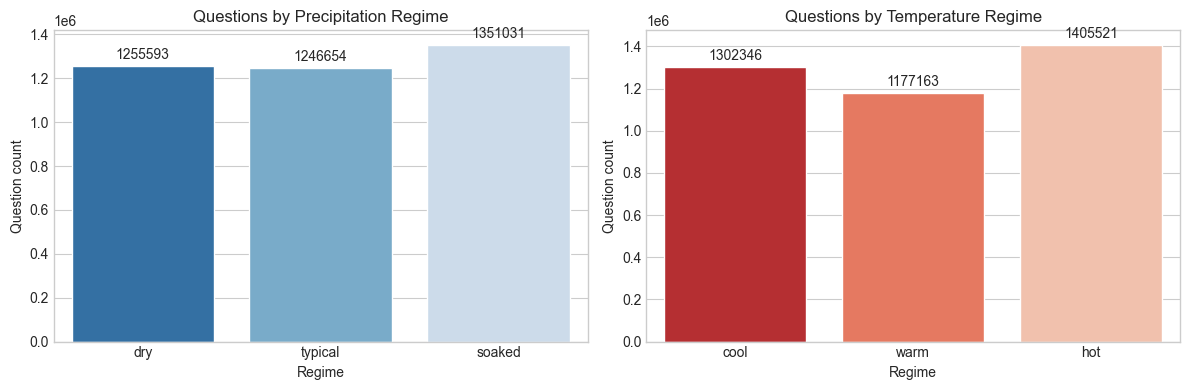

In [19]:
# 22.1c Visualize volume shifts across regimes
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
if not volume_by_precip.empty:
    sns.barplot(
        data=volume_by_precip,
        x='precip_regime',
        y='question_count',
        hue='precip_regime',
        palette='Blues_r',
        ax=axes[0],
        legend=False,
    )
    axes[0].set_title('Questions by Precipitation Regime')
    axes[0].set_xlabel('Regime')
    axes[0].set_ylabel('Question count')
    for container in axes[0].containers:
        axes[0].bar_label(container, fmt='%.0f', padding=3)
else:
    axes[0].set_visible(False)
if not volume_by_temp.empty:
    sns.barplot(
        data=volume_by_temp,
        x='temp_regime',
        y='question_count',
        hue='temp_regime',
        palette='Reds_r',
        ax=axes[1],
        legend=False,
    )
    axes[1].set_title('Questions by Temperature Regime')
    axes[1].set_xlabel('Regime')
    axes[1].set_ylabel('Question count')
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt='%.0f', padding=3)
else:
    axes[1].set_visible(False)
plt.tight_layout()
plt.show()

In [20]:
# 22.1a Compact preview of topic-share tables
print('Precip regimes captured:', topic_share_precip['precip_regime'].unique() if not topic_share_precip.empty else 'n/a')
display(topic_share_precip.head(15))
print('\nTemp regimes captured:', topic_share_temp['temp_regime'].unique() if not topic_share_temp.empty else 'n/a')
display(topic_share_temp.head(15))

Precip regimes captured: ['dry', 'typical', 'soaked']
Categories (3, object): ['dry' < 'typical' < 'soaked']


,precip_regime,question_topic,topic_share
98,dry,other,0.150469
82,dry,maize,0.110765
37,dry,chicken,0.105986
31,dry,cattle,0.097171
113,dry,poultry,0.065748
247,typical,other,0.147077
231,typical,maize,0.125195
180,typical,cattle,0.099545
186,typical,chicken,0.086523
262,typical,poultry,0.058199



Temp regimes captured: ['cool', 'warm', 'hot']
Categories (3, object): ['cool' < 'warm' < 'hot']


,temp_regime,question_topic,topic_share
98,cool,other,0.147976
82,cool,maize,0.102242
31,cool,cattle,0.101006
37,cool,chicken,0.088331
141,cool,tomato,0.070630
247,warm,other,0.139531
231,warm,maize,0.125423
180,warm,cattle,0.105697
186,warm,chicken,0.102980
262,warm,poultry,0.067593


In [21]:
# 22.1b Text summaries for referencing in write-up
def summarize_topic_shares(df, regime_col):
    if df.empty:
        return {}
    summary = {}
    for regime, group in df.groupby(regime_col, observed=False):
        summary[str(regime)] = [
            {'topic': topic, 'share_pct': round(share * 100, 1)}
            for topic, share in zip(group['question_topic'], group['topic_share'])
        ]
    return summary
precip_topic_summary = summarize_topic_shares(topic_share_precip, 'precip_regime')
temp_topic_summary = summarize_topic_shares(topic_share_temp, 'temp_regime')
print('Precip topic summary:', precip_topic_summary)
print('\nTemp topic summary:', temp_topic_summary)

Precip topic summary: {'dry': [{'topic': 'other', 'share_pct': 15.0}, {'topic': 'maize', 'share_pct': 11.1}, {'topic': 'chicken', 'share_pct': 10.6}, {'topic': 'cattle', 'share_pct': 9.7}, {'topic': 'poultry', 'share_pct': 6.6}], 'typical': [{'topic': 'other', 'share_pct': 14.7}, {'topic': 'maize', 'share_pct': 12.5}, {'topic': 'cattle', 'share_pct': 10.0}, {'topic': 'chicken', 'share_pct': 8.7}, {'topic': 'poultry', 'share_pct': 5.8}], 'soaked': [{'topic': 'other', 'share_pct': 16.4}, {'topic': 'maize', 'share_pct': 13.0}, {'topic': 'cattle', 'share_pct': 10.0}, {'topic': 'poultry', 'share_pct': 7.7}, {'topic': 'chicken', 'share_pct': 7.7}]}

Temp topic summary: {'cool': [{'topic': 'other', 'share_pct': 14.8}, {'topic': 'maize', 'share_pct': 10.2}, {'topic': 'cattle', 'share_pct': 10.1}, {'topic': 'chicken', 'share_pct': 8.8}, {'topic': 'tomato', 'share_pct': 7.1}], 'warm': [{'topic': 'other', 'share_pct': 14.0}, {'topic': 'maize', 'share_pct': 12.5}, {'topic': 'cattle', 'share_pct': 

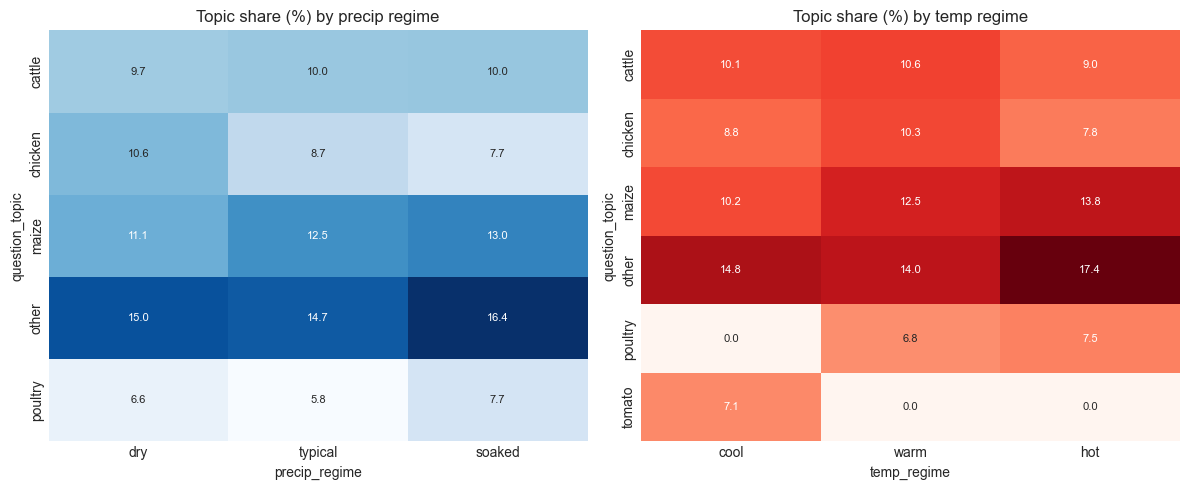

In [22]:
# 22.2c Visualize topic share shifts
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
if not topic_share_precip.empty:
    heatmap_precip = topic_share_precip.pivot(
        index='question_topic',
        columns='precip_regime',
        values='topic_share',
    ).fillna(0) * 100
    sns.heatmap(
        heatmap_precip,
        annot=True,
        fmt='.1f',
        cmap='Blues',
        ax=axes[0],
        cbar=False,
        annot_kws={'fontsize': 8},
    )
    axes[0].set_title('Topic share (%) by precip regime')
else:
    axes[0].set_visible(False)
if not topic_share_temp.empty:
    heatmap_temp = topic_share_temp.pivot(
        index='question_topic',
        columns='temp_regime',
        values='topic_share',
    ).fillna(0) * 100
    sns.heatmap(
        heatmap_temp,
        annot=True,
        fmt='.1f',
        cmap='Reds',
        ax=axes[1],
        cbar=False,
        annot_kws={'fontsize': 8},
    )
    axes[1].set_title('Topic share (%) by temp regime')
else:
    axes[1].set_visible(False)
plt.tight_layout()
plt.show()

In [29]:
# 22.2 Simple predictive test: can rolling weather anticipate dominant topics?
# Add two additional models (Random Forest + Gradient Boosting) for comparison.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings('ignore', category=ConvergenceWarning)

feature_cols = precip_cols + temp_cols
feature_cols = [col for col in feature_cols if col in merged_df.columns]
if not feature_cols:
    raise ValueError('No weather feature columns available for modeling. Run Section 21 first.')
model_df = merged_df.dropna(subset=feature_cols + ['question_topic']).copy()
top_topics = model_df['question_topic'].value_counts().head(6).index.tolist()
model_df = model_df[model_df['question_topic'].isin(top_topics)].copy()
if len(model_df) < 10000:
    raise ValueError('Not enough records with weather features to run predictive test.')

X = model_df[feature_cols]
y = model_df['question_topic']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
 )
baseline = y_test.value_counts(normalize=True).max()

models = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=2000))
    ]),
    'RandomForest': RandomForestClassifier(
        n_estimators=300, max_depth=12, random_state=42, n_jobs=-1, class_weight='balanced_subsample'
    ),
    'GradientBoosting': Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingClassifier(random_state=42, subsample=0.8))
    ]),
}

comparison_rows = []
per_topic_f1 = {}
for name, estimator in models.items():
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    macro = f1_score(y_test, y_pred, average='macro')
    comparison_rows.append({'model': name, 'accuracy': acc, 'macro_f1': macro})
    report = classification_report(y_test, y_pred, output_dict=True)
    per_topic_f1[name] = {label: metrics['f1-score'] for label, metrics in report.items() if label in top_topics}

comparison_df = pd.DataFrame(comparison_rows).sort_values('accuracy', ascending=False)
print(f"Baseline (majority class) accuracy: {baseline:.3f}")
display(comparison_df)

print('\nPer-topic F1 (weather-only signal):')
for name, scores in per_topic_f1.items():
    print(f"- {name}:")
    for topic, score in scores.items():
        print(f"    {topic}: {score:.3f}")

C:\Users\POWER COMPUTER\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\POWER COMPUTER\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\POWER COMPUTER\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

Baseline (majority class) accuracy: 0.264


,model,accuracy,macro_f1
2,GradientBoosting,0.332896,0.265545
1,RandomForest,0.318133,0.310893
0,LogisticRegression,0.284538,0.151292



Per-topic F1 (weather-only signal):
- LogisticRegression:
    cattle: 0.211
    chicken: 0.011
    maize: 0.276
    other: 0.411
    poultry: 0.000
    tomato: 0.000
- RandomForest:
    cattle: 0.355
    chicken: 0.306
    maize: 0.295
    other: 0.326
    poultry: 0.317
    tomato: 0.267
- GradientBoosting:
    cattle: 0.277
    chicken: 0.224
    maize: 0.314
    other: 0.439
    poultry: 0.093
    tomato: 0.246


In [17]:
# 22.3 Identify crop/region columns for sensitivity checks
crop_cols = [c for c in merged_df.columns if 'crop' in c.lower() or 'commodity' in c.lower()]
region_cols = [c for c in merged_df.columns if 'region' in c.lower() or 'district' in c.lower()]
print('Crop-like columns:', crop_cols)
print('Region-like columns:', region_cols)

Crop-like columns: []
Region-like columns: []


In [23]:
# 22.4 Crop/topic and country sensitivity to precipitation regimes
topic_regime_shift = (
    topic_share_precip.pivot(
        index='precip_regime', columns='question_topic', values='topic_share'
    )
    .T
    .pipe(lambda df: df.mul(100))
    .assign(max_delta_pct=lambda df: df.max(axis=1) - df.min(axis=1))
    .sort_values('max_delta_pct', ascending=False)
 )
topic_regime_shift.head()

precip_regime,dry,typical,soaked,max_delta_pct
question_topic,,,,
chicken,10.598604,8.652334,7.659758,2.938847
maize,11.076457,12.519509,13.030826,1.954369
poultry,6.574806,5.819897,7.720781,1.900884
other,15.046939,14.707653,16.407940,1.700287
cattle,9.717105,9.954549,9.986478,0.269373


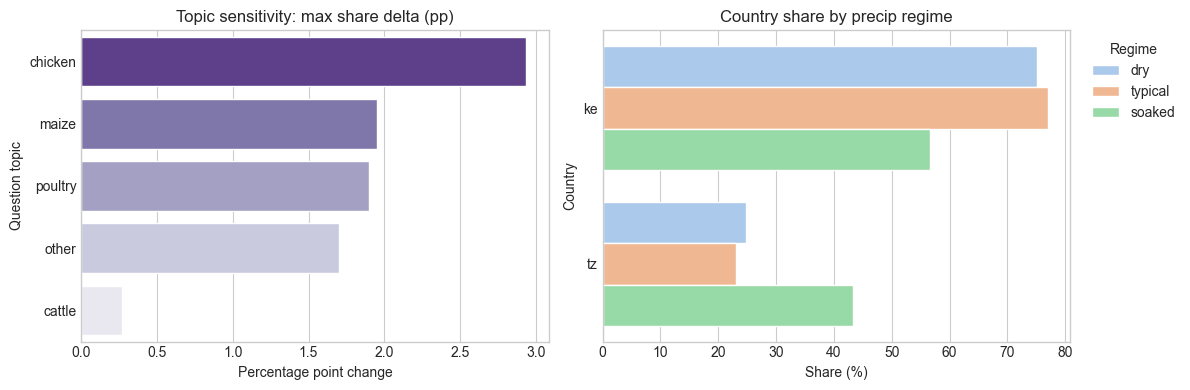

In [24]:
# 22.4b Visualizing regimes where questions diverge
# First compute country_regime_shift
if 'question_user_country_code' in regime_df.columns and 'precip_regime' in regime_df.columns:
    country_counts = (
        regime_df.dropna(subset=['precip_regime', 'question_user_country_code'])
        .groupby(['precip_regime', 'question_user_country_code'], observed=False)['question_identifier']
        .count()
        .reset_index(name='question_count')
    )
    country_totals = country_counts.groupby('precip_regime', observed=False)['question_count'].sum().rename('regime_total')
    country_regime_shift = (
        country_counts.merge(country_totals, on='precip_regime')
        .assign(share=lambda df_: df_['question_count'] / df_['regime_total'])
        .pivot(index='question_user_country_code', columns='precip_regime', values='share')
        .fillna(0)
        .assign(max_delta=lambda df: df.max(axis=1) - df.min(axis=1))
        .sort_values('max_delta', ascending=False)
    )
else:
    country_regime_shift = pd.DataFrame()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
if not topic_regime_shift.empty:
    plot_topics = (
        topic_regime_shift.reset_index()[['question_topic', 'max_delta_pct']]
        .sort_values('max_delta_pct', ascending=False)
        .head(6)
    )
    sns.barplot(
        data=plot_topics,
        x='max_delta_pct',
        y='question_topic',
        hue='question_topic',
        palette='Purples_r',
        ax=axes[0],
        legend=False,
    )
    axes[0].set_title('Topic sensitivity: max share delta (pp)')
    axes[0].set_xlabel('Percentage point change')
    axes[0].set_ylabel('Question topic')
else:
    axes[0].set_visible(False)
if not country_regime_shift.empty:
    melted_country = (
        country_regime_shift.reset_index()
        .rename(columns={'question_user_country_code': 'country'})
        .drop(columns=[col for col in ['max_delta'] if col in country_regime_shift.columns])
        .melt(id_vars='country', var_name='precip_regime', value_name='share_pct')
    )
    melted_country['share_pct'] = melted_country['share_pct'] * 100
    sns.barplot(
        data=melted_country,
        x='share_pct',
        y='country',
        hue='precip_regime',
        ax=axes[1],
        palette='pastel',
    )
    axes[1].set_title('Country share by precip regime')
    axes[1].set_xlabel('Share (%)')
    axes[1].set_ylabel('Country')
    axes[1].legend(title='Regime', bbox_to_anchor=(1.02, 1), loc='upper left')
else:
    axes[1].set_visible(False)
plt.tight_layout()
plt.show()

In [25]:
# 22.4a Text summary of largest topic deltas
if not topic_regime_shift.empty:
    topic_regime_shift_reset = topic_regime_shift.reset_index()
    top_deltas = topic_regime_shift_reset[['question_topic', 'max_delta_pct']].head(10)
    print('Top topic deltas (percentage points):')
    print(top_deltas)
else:
    print('Topic regime shift table is empty')
print('\nCountry precip share deltas (rounded):')
if not country_regime_shift.empty and 'max_delta' in country_regime_shift.columns:
    print(country_regime_shift['max_delta'].round(3).to_dict())
else:
    print('Country table empty or max_delta not computed')

Top topic deltas (percentage points):
precip_regime question_topic  max_delta_pct
0                    chicken       2.938847
1                      maize       1.954369
2                    poultry       1.900884
3                      other       1.700287
4                     cattle       0.269373

Country precip share deltas (rounded):
{'ke': 0.203, 'tz': 0.203}


### 23. Weather-aware timelines and forecast experiments

In [26]:
# 23.2 Stretch: weekly topic leader forecast from weather features
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

required_weather = [
    'PRCP_roll7d_sum',
    'PRCP_roll30d_sum',
    'TAVG_roll7d_mean',
    'TAVG_roll30d_mean',
]
if 'ts_df' not in globals() or 'week_start' not in ts_df.columns:
    if 'merged_df' not in globals():
        raise RuntimeError("Run the Section 23 merge cell first so 'merged_df' exists before forecasting.")
    ts_df = merged_df.copy()
else:
    ts_df = ts_df.copy()

date_source = next(
    (col for col in ['question_sent_ts', 'question_sent_dt', 'question_sent'] if col in ts_df.columns),
    None,
 )
if date_source is None:
    raise RuntimeError("No question timestamp column found (expected question_sent_dt or question_sent).")
ts_df['question_sent_ts'] = pd.to_datetime(ts_df[date_source], utc=True, errors='coerce')
ts_df = ts_df.dropna(subset=['question_sent_ts', 'question_topic'])

missing_weather = [col for col in required_weather if col not in ts_df.columns]
if missing_weather:
    raise RuntimeError(f"Missing required weather features for the weekly forecast: {missing_weather}")
ts_df = ts_df.dropna(subset=required_weather)
ts_df['week_start'] = ts_df['question_sent_ts'].dt.to_period('W').dt.start_time

weekly_weather = (
    ts_df.groupby('week_start')
    .agg(
        prcp7=('PRCP_roll7d_sum', 'mean'),
        prcp30=('PRCP_roll30d_sum', 'mean'),
        tavg7=('TAVG_roll7d_mean', 'mean'),
        tavg30=('TAVG_roll30d_mean', 'mean'),
    )
    .reset_index()
 )
weekly_topic = (
    ts_df.groupby(['week_start', 'question_topic'])
    .size()
    .reset_index(name='topic_count')
 )
weekly_topic = weekly_topic.sort_values(['week_start', 'topic_count'], ascending=[True, False])
top_topic_week = weekly_topic.drop_duplicates('week_start')[['week_start', 'question_topic']]
weekly_ml = weekly_weather.merge(top_topic_week, on='week_start').dropna()
weekly_ml['week_start'] = pd.to_datetime(weekly_ml['week_start'])
cutoff = pd.Timestamp('2020-01-01')
train_df = weekly_ml[weekly_ml['week_start'] < cutoff]
test_df = weekly_ml[weekly_ml['week_start'] >= cutoff]
feature_cols = ['prcp7', 'prcp30', 'tavg7', 'tavg30']
X_train, y_train = train_df[feature_cols], train_df['question_topic']
X_test, y_test = test_df[feature_cols], test_df['question_topic']
baseline = y_test.value_counts(normalize=True).max() if len(y_test) else float('nan')
clf = Pipeline(
    steps=[
        ('scale', StandardScaler()),
        ('lr', LogisticRegression(max_iter=500)),
    ]
 )
if len(X_train) > 5 and len(X_test) > 0:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Weekly leader accuracy: {acc:.3f} (baseline {baseline:.3f})")
    print(classification_report(y_test, y_pred))
    scenario_inputs = pd.DataFrame(
        {
            'prcp7': [5, 25, 60],
            'prcp30': [40, 120, 250],
            'tavg7': [18, 22, 27],
            'tavg30': [19, 23, 28],
        },
        index=['Dry+Cool', 'Seasonal+Mild', 'Soaked+Hot'],
    )
    scenario_preds = clf.predict_proba(scenario_inputs)
    forecast_table = pd.DataFrame(
        scenario_preds, columns=clf.classes_, index=scenario_inputs.index
 )
    print("Scenario topic probabilities (rows sum to 1):")
    display((forecast_table * 100).round(1))
else:
    print("Not enough weekly samples after split to train the stretch model.")

C:\Users\POWER COMPUTER\AppData\Local\Temp\ipykernel_2644\3567319676.py:33: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  ts_df['week_start'] = ts_df['question_sent_ts'].dt.to_period('W').dt.start_time


Weekly leader accuracy: 0.639 (baseline 0.705)
              precision    recall  f1-score   support

        bird       0.00      0.00      0.00         1
     cabbage       0.00      0.00      0.00         1
      cattle       0.00      0.00      0.00         7
     chicken       0.00      0.00      0.00         4
        crop       0.00      0.00      0.00         2
       maize       0.00      0.00      0.00        12
       other       0.68      0.91      0.78        86
       plant       0.00      0.00      0.00         2
     poultry       0.00      0.00      0.00         3
       sheep       0.00      0.00      0.00         1
      tomato       0.00      0.00      0.00         3

    accuracy                           0.64       122
   macro avg       0.06      0.08      0.07       122
weighted avg       0.48      0.64      0.55       122

Scenario topic probabilities (rows sum to 1):


C:\Users\POWER COMPUTER\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\POWER COMPUTER\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\POWER COMPUTER\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

,bean,cattle,chicken,maize,other,rabbit,tomato
Dry+Cool,0.0,0.0,0.0,0.0,0.0,0.0,100.0
Seasonal+Mild,0.0,7.5,0.0,0.0,1.8,0.0,90.7
Soaked+Hot,0.0,0.0,0.0,0.0,100.0,0.0,0.0


In [27]:
# 23.0 Quick data snapshot (columns, date coverage)
cols = sorted(merged_df.columns.tolist())
print(f"Merged rows: {len(merged_df):,}")
print(f"Question date range: {merged_df['question_sent'].min()} -> {merged_df['question_sent'].max()}")
print(f"Sample columns ({len(cols)} total):")
print(cols[:20])

Merged rows: 13,992,333
Question date range: 2017-11-22 00:00:00 -> 2022-06-21 00:00:00
Sample columns (36 total):
['DATE', 'PRCP', 'PRCP_filled', 'PRCP_roll30d_sum', 'PRCP_roll7d_sum', 'SNWD', 'TAVG', 'TAVG_filled', 'TAVG_roll30d_mean', 'TAVG_roll7d_mean', 'TMAX', 'TMAX_filled', 'TMAX_roll30d_mean', 'TMAX_roll7d_mean', 'TMIN', 'TMIN_filled', 'TMIN_roll30d_mean', 'TMIN_roll7d_mean', '_merge', 'country']
Question date range: 2017-11-22 00:00:00 -> 2022-06-21 00:00:00
Sample columns (36 total):
['DATE', 'PRCP', 'PRCP_filled', 'PRCP_roll30d_sum', 'PRCP_roll7d_sum', 'SNWD', 'TAVG', 'TAVG_filled', 'TAVG_roll30d_mean', 'TAVG_roll7d_mean', 'TMAX', 'TMAX_filled', 'TMAX_roll30d_mean', 'TMAX_roll7d_mean', 'TMIN', 'TMIN_filled', 'TMIN_roll30d_mean', 'TMIN_roll7d_mean', '_merge', 'country']


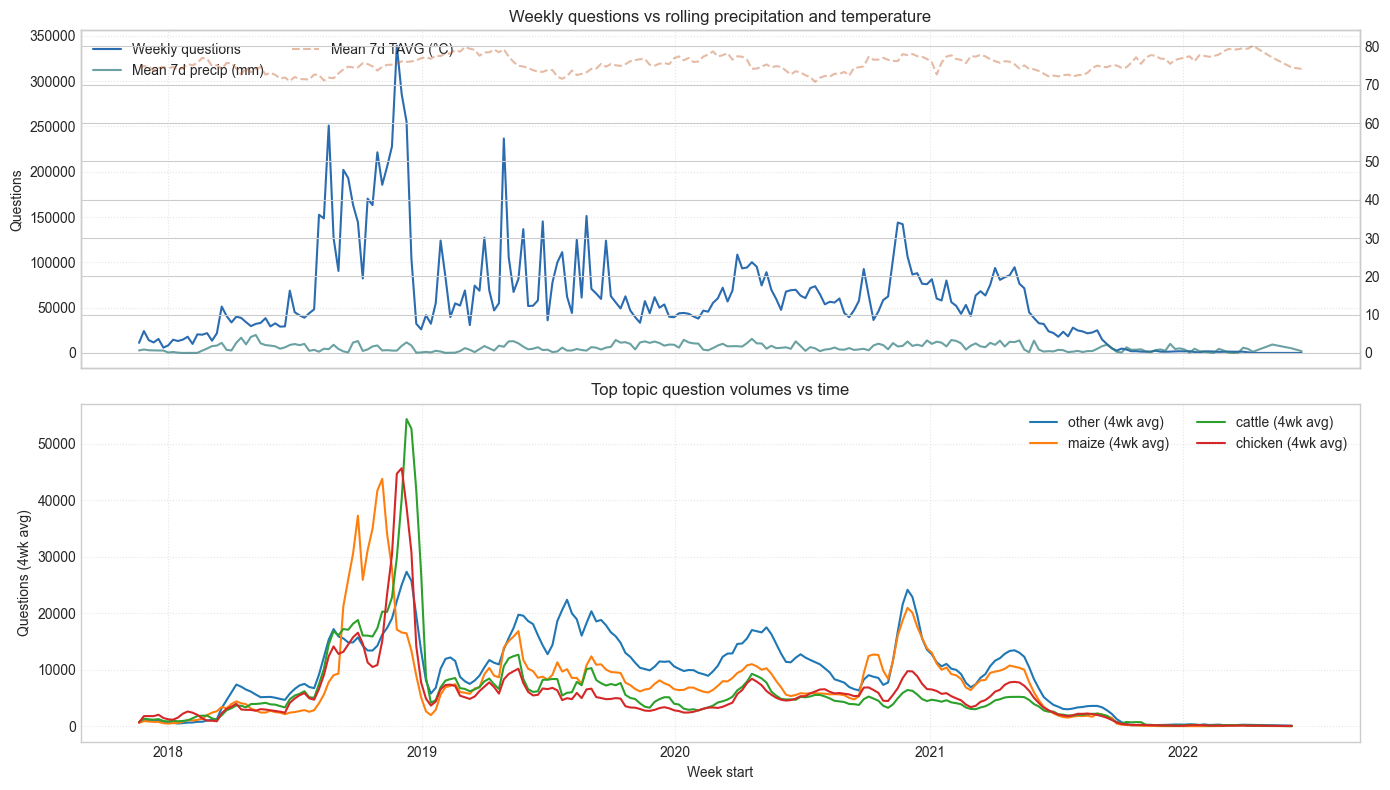

In [28]:
# 23.1 Time series: questions vs weather + top topics
ts_df = merged_df.copy()
ts_df['week_start'] = ts_df['question_sent'].dt.to_period('W').dt.start_time
weekly_summary = (
    ts_df.groupby('week_start')
    .agg(
        question_count=('question_topic', 'size'),
        precip_roll7d=('PRCP_roll7d_sum', 'mean'),
        temp_roll7d=('TAVG_roll7d_mean', 'mean'),
    )
    .reset_index()
)
top_topics = merged_df['question_topic'].value_counts().head(4).index.tolist()
topic_weekly = (
    ts_df[ts_df['question_topic'].isin(top_topics)]
    .groupby(['week_start', 'question_topic'])
    .size()
    .reset_index(name='topic_count')
)
topic_pivot = topic_weekly.pivot(
    index='week_start', columns='question_topic', values='topic_count'
).fillna(0)
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
# Panel A: total questions vs weather
axes[0].plot(
    weekly_summary['week_start'],
    weekly_summary['question_count'],
    color='#2B6CB0',
    label='Weekly questions',
)
axes[0].set_ylabel('Questions')
axes[0].set_title('Weekly questions vs rolling precipitation and temperature')
ax2 = axes[0].twinx()
ax2.plot(
    weekly_summary['week_start'],
    weekly_summary['precip_roll7d'],
    color='#2C7A7B',
    label='Mean 7d precip (mm)',
    alpha=0.7,
)
ax2.plot(
    weekly_summary['week_start'],
    weekly_summary['temp_roll7d'],
    color='#C05621',
    label='Mean 7d TAVG (Â°C)',
    alpha=0.4,
    linestyle='--',
)
axes[0].grid(True, linestyle=':', alpha=0.5)
handles0, labels0 = axes[0].get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
axes[0].legend(handles0 + handles2, labels0 + labels2, loc='upper left', ncol=2)
# Panel B: top topic volumes
for topic in top_topics:
    if topic in topic_pivot.columns:
        axes[1].plot(
            topic_pivot.index,
            topic_pivot[topic].rolling(4, min_periods=1).mean(),
            label=f"{topic} (4wk avg)",
        )
axes[1].set_ylabel('Questions (4wk avg)')
axes[1].set_xlabel('Week start')
axes[1].set_title('Top topic question volumes vs time')
axes[1].legend(ncol=2)
axes[1].grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

## 24. Uganda Monthly Weather & Topic Patterns
Load the national monthly climate indicators (dry days `CDD`, wet days `CWD`, and mean temperature `TAS`) and align them with Uganda-specific questions to mirror the Kenya/Tanzania analysis without rolling windows.

In [29]:
# 24.0 Load & tidy Uganda monthly climate records
import pandas as pd
from functools import reduce
if 'UGANDA_PATH' not in globals():
    raise RuntimeError('UGANDA_PATH is undefined; re-run the weather setup cell (Section 21) before Section 24.')
UGANDA_SHEETS = {
    'cdd_days': 'cdd_1950-2023',  # consecutive dry days
    'cwd_days': 'cwd_1950-2023',  # consecutive wet days
    'tas_celsius': 'tas_1950-2023',  # mean temperature in Â°C
}

def tidy_uganda_sheet(sheet_name: str, value_name: str) -> pd.DataFrame:
    raw = pd.read_excel(UGANDA_PATH, sheet_name=sheet_name)
    id_cols = [col for col in ['code', 'name'] if col in raw.columns]
    month_cols = [col for col in raw.columns if isinstance(col, str) and col[:4].isdigit()]
    tidy = raw.melt(
        id_vars=id_cols, value_vars=month_cols, var_name='month', value_name=value_name
    )
    tidy['month'] = pd.PeriodIndex(tidy['month'], freq='M').to_timestamp('M')
    tidy[value_name] = pd.to_numeric(tidy[value_name], errors='coerce')
    return tidy.dropna(subset=[value_name])

uganda_frames = [tidy_uganda_sheet(sheet, name) for name, sheet in UGANDA_SHEETS.items()]
merge_keys = ['month'] + [col for col in ['code', 'name'] if col in uganda_frames[0].columns]
uganda_weather_monthly = reduce(
    lambda left, right: left.merge(right, on=merge_keys, how='outer'), uganda_frames
).sort_values('month').reset_index(drop=True)
uganda_weather_monthly['tas_fahrenheit'] = (uganda_weather_monthly['tas_celsius'] * 9 / 5) + 32
print(f"Uganda weather monthly rows: {len(uganda_weather_monthly):,}")
print(uganda_weather_monthly[['month', 'cdd_days', 'cwd_days', 'tas_celsius']].dropna().head())
print('\nMost recent months:')
display(uganda_weather_monthly[['month', 'cdd_days', 'cwd_days', 'tas_celsius', 'tas_fahrenheit']].tail(12))

Uganda weather monthly rows: 888
       month  cdd_days  cwd_days  tas_celsius
0 1950-01-31      7.80      9.51        22.07
1 1950-02-28     11.18     10.17        22.94
2 1950-03-31      7.99     20.60        21.62
3 1950-04-30      1.84     21.94        21.17
4 1950-05-31      2.72     25.32        20.62

Most recent months:


,month,cdd_days,cwd_days,tas_celsius,tas_fahrenheit
876,2023-01-31,18.72,2.21,24.48,76.064
877,2023-02-28,20.16,3.31,25.68,78.224
878,2023-03-31,9.54,10.69,23.52,74.336
879,2023-04-30,5.11,10.32,23.51,74.318
880,2023-05-31,5.24,12.63,24.05,75.290
881,2023-06-30,6.56,10.65,23.52,74.336
882,2023-07-31,14.16,6.99,23.74,74.732
883,2023-08-31,9.46,5.69,24.33,75.794
884,2023-09-30,3.79,13.70,23.72,74.696
885,2023-10-31,4.86,12.12,23.85,74.930


### 24.0.1 Visualize Uganda climate trends
Line charts for monthly CDD/CWD/TAS to show long-term swings.

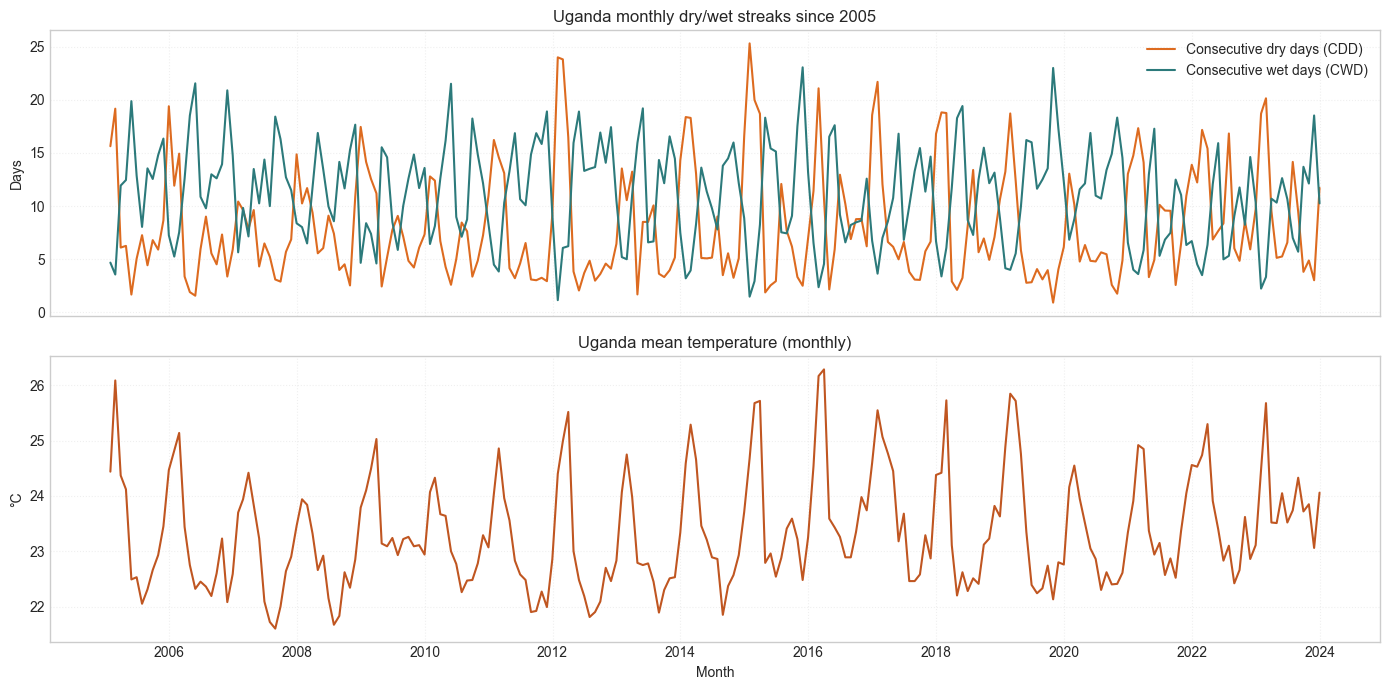

In [30]:
# 24.0a climate visualization
recent_years = uganda_weather_monthly[uganda_weather_monthly['month'] >= '2005-01-01'].dropna(subset=['cdd_days', 'cwd_days', 'tas_celsius'])
if recent_years.empty:
    print('Uganda climate visual skipped: insufficient recent data after filtering.')
else:
    fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
    axes[0].plot(recent_years['month'], recent_years['cdd_days'], label='Consecutive dry days (CDD)', color='#DD6B20')
    axes[0].plot(recent_years['month'], recent_years['cwd_days'], label='Consecutive wet days (CWD)', color='#2C7A7B')
    axes[0].set_ylabel('Days')
    axes[0].set_title('Uganda monthly dry/wet streaks since 2005')
    axes[0].legend(loc='upper right')
    axes[0].grid(alpha=0.3, linestyle=':')
    axes[1].plot(recent_years['month'], recent_years['tas_celsius'], label='Mean temperature (Â°C)', color='#C05621')
    axes[1].set_ylabel('Â°C')
    axes[1].set_xlabel('Month')
    axes[1].set_title('Uganda mean temperature (monthly)')
    axes[1].grid(alpha=0.3, linestyle=':')
    plt.tight_layout()
    plt.show()

### 24.1 Align Uganda questions with monthly climate signals
Restrict the question dataset to Uganda, convert timestamps to monthly buckets, and merge in the CDD/CWD/TAS metrics.

In [31]:
# 24.1 Merge Uganda questions with monthly weather
UG_CODES = {'ug'}
if 'clean_df' not in globals():
    raise RuntimeError('clean_df is unavailable; re-run earlier cells to recreate it before Section 24.')
uganda_questions = clean_df[
    clean_df['question_user_country_code'].str.lower().isin(UG_CODES)
].copy()
if uganda_questions.empty:
    raise ValueError('No Uganda questions found in clean_df. Verify earlier filtering steps.')
id_col = 'question_id' if 'question_id' in uganda_questions.columns else uganda_questions.columns[0]
uganda_questions = uganda_questions.rename(columns={id_col: 'question_identifier'})
uganda_questions['question_sent'] = pd.to_datetime(uganda_questions['question_sent'], errors='coerce')
uganda_questions['question_month'] = uganda_questions['question_sent'].dt.to_period('M').dt.to_timestamp('M')
uganda_enriched = uganda_questions.merge(
    uganda_weather_monthly[['month', 'cdd_days', 'cwd_days', 'tas_celsius', 'tas_fahrenheit']],
    left_on='question_month',
    right_on='month',
    how='left',
    suffixes=('', '_uganda_weather')
)
uganda_enriched = uganda_enriched.drop(columns=['month'])
print(f"Uganda question rows: {len(uganda_enriched):,}")
print('Coverage of climate joins:')
print(uganda_enriched[['cdd_days', 'cwd_days', 'tas_celsius']].notna().mean())
monthly_question_counts = (
    uganda_enriched.groupby('question_month').size().rename('question_count').reset_index()
)
display(monthly_question_counts.tail(12))

C:\Users\POWER COMPUTER\AppData\Local\Temp\ipykernel_2644\1805261411.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  uganda_questions['question_month'] = uganda_questions['question_sent'].dt.to_period('M').dt.to_timestamp('M')


Uganda question rows: 6,312,194
Coverage of climate joins:
cdd_days       1.0
cwd_days       1.0
tas_celsius    1.0
dtype: float64


,question_month,question_count
35,2020-10-31,224490
36,2020-11-30,215076
37,2020-12-31,108474
38,2021-01-31,101060
39,2021-02-28,119390
40,2021-03-31,101602
41,2021-04-30,40988
42,2021-05-31,33957
43,2021-06-30,39832
44,2021-07-31,68563


### 24.1.1 Uganda questions vs monthly climate
Overlay monthly question counts with national CDD/CWD/TAS averages.

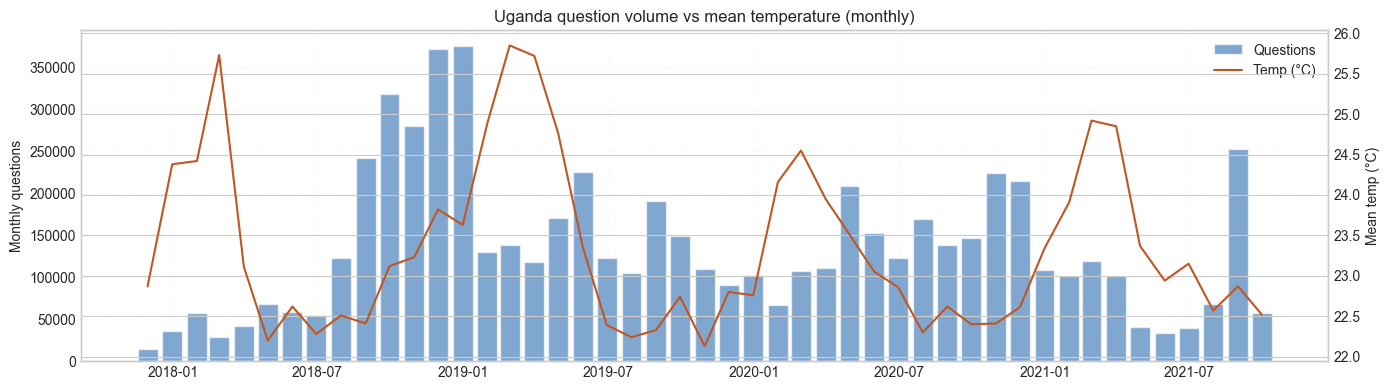

In [32]:
# 24.1a visualization
plot_data = uganda_enriched[['question_month', 'tas_celsius']].copy()
plot_data['question_count'] = 1
plot_data = plot_data.groupby('question_month').agg({'question_count': 'sum', 'tas_celsius': 'mean'}).reset_index()
recent = plot_data[plot_data['question_month'] >= '2015-01-01']
if recent.empty:
    print('Uganda question climate visual skipped: insufficient post-2015 data.')
else:
    fig, ax1 = plt.subplots(figsize=(14, 4))
    ax1.bar(recent['question_month'], recent['question_count'], width=25, color='#2B6CB0', alpha=0.6, label='Questions')
    ax1.set_ylabel('Monthly questions')
    ax1.set_title('Uganda question volume vs mean temperature (monthly)')
    ax1.grid(alpha=0.2, linestyle=':')
    ax2 = ax1.twinx()
    ax2.plot(recent['question_month'], recent['tas_celsius'], color='#C05621', label='Temp (Â°C)')
    ax2.set_ylabel('Mean temp (Â°C)')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.tight_layout()
    plt.show()

### 24.2 Monthly regime diagnostics and topic shifts
Bucket CDD/CWD/TAS into coarse regimes (low/typical/high) to mirror the earlier precipitation/temperature analysis without rolling windows.

In [33]:
# 24.2 Regime classification and topic impact
def safe_bucket_monthly(series: pd.Series, labels: list[str]):
    clean = series.dropna()
    if clean.empty:
        return pd.Series(pd.NA, index=series.index)
    n_labels = min(len(labels), max(1, clean.nunique()))
    use_labels = labels[:n_labels]
    try:
        return pd.qcut(series, q=n_labels, labels=use_labels, duplicates='drop')
    except ValueError:
        return pd.cut(series, bins=n_labels, labels=use_labels)

uganda_regimes = uganda_enriched.copy()
if 'cdd_days' in uganda_regimes.columns:
    uganda_regimes['dryspell_regime'] = safe_bucket_monthly(
        uganda_regimes['cdd_days'], ['few_dry_days', 'typical_dry_days', 'prolonged_dry_days']
    )
if 'cwd_days' in uganda_regimes.columns:
    uganda_regimes['wetspell_regime'] = safe_bucket_monthly(
        uganda_regimes['cwd_days'], ['few_wet_days', 'typical_wet_days', 'persistent_wet_days']
    )
if 'tas_celsius' in uganda_regimes.columns:
    uganda_regimes['temp_regime'] = safe_bucket_monthly(
        uganda_regimes['tas_celsius'], ['cool', 'warm', 'hot']
    )

def summarize_volume(df: pd.DataFrame, regime_col: str) -> pd.DataFrame:
    if regime_col not in df.columns:
        return pd.DataFrame()
    subset = df.dropna(subset=[regime_col])
    return (
        subset.groupby(regime_col,observed=False)['question_identifier' if 'question_identifier' in subset.columns else subset.columns[0]]
        .nunique()
        .reset_index(name='question_count')
    )

def summarize_topics(df: pd.DataFrame, regime_col: str) -> pd.DataFrame:
    if regime_col not in df.columns or 'question_topic' not in df.columns:
        return pd.DataFrame()
    subset = df.dropna(subset=[regime_col, 'question_topic'])
    topic_counts = (
        subset.groupby([regime_col, 'question_topic'], observed=False)['question_topic']
        .count()
        .rename('question_count')
        .reset_index()
    )
    totals = topic_counts.groupby(regime_col, observed=False)['question_count'].sum().rename('regime_total')
    return (
        topic_counts.merge(totals, on=regime_col)
        .assign(topic_share=lambda d: d['question_count'] / d['regime_total'])
        .sort_values([regime_col, 'topic_share'], ascending=[True, False])
        .groupby(regime_col, observed=False)
        .head(5)
    )

dry_volume = summarize_volume(uganda_regimes, 'dryspell_regime')
wet_volume = summarize_volume(uganda_regimes, 'wetspell_regime')
temp_volume = summarize_volume(uganda_regimes, 'temp_regime')
dry_topics = summarize_topics(uganda_regimes, 'dryspell_regime')
wet_topics = summarize_topics(uganda_regimes, 'wetspell_regime')
temp_topics = summarize_topics(uganda_regimes, 'temp_regime')

print('Uganda question volume by regime (dry/wet/temp):')
display(dry_volume)
display(wet_volume)
display(temp_volume)
print('\nTop topics within each regime:')
display(dry_topics)
display(wet_topics)
display(temp_topics)

Uganda question volume by regime (dry/wet/temp):


,dryspell_regime,question_count
0,few_dry_days,743012
1,typical_dry_days,573837
2,prolonged_dry_days,657873


,wetspell_regime,question_count
0,few_wet_days,710011
1,typical_wet_days,612127
2,persistent_wet_days,652584


,temp_regime,question_count
0,cool,724909
1,warm,630849
2,hot,618964



Top topics within each regime:


,dryspell_regime,question_topic,question_count,regime_total,topic_share
97,few_dry_days,other,534252,2232907,0.239263
81,few_dry_days,maize,132797,2232907,0.059473
37,few_dry_days,chicken,130301,2232907,0.058355
138,few_dry_days,tomato,128706,2232907,0.057641
109,few_dry_days,plant,121399,2232907,0.054368
243,typical_dry_days,other,320973,2051030,0.156494
227,typical_dry_days,maize,245381,2051030,0.119638
284,typical_dry_days,tomato,148684,2051030,0.072492
255,typical_dry_days,plant,118707,2051030,0.057877
183,typical_dry_days,chicken,116554,2051030,0.056827


,wetspell_regime,question_topic,question_count,regime_total,topic_share
97,few_wet_days,other,561814,2198838,0.255505
37,few_wet_days,chicken,172269,2198838,0.078345
81,few_wet_days,maize,130996,2198838,0.059575
138,few_wet_days,tomato,104708,2198838,0.047620
109,few_wet_days,plant,103704,2198838,0.047163
243,typical_wet_days,other,364581,2044536,0.178320
227,typical_wet_days,maize,202418,2044536,0.099004
284,typical_wet_days,tomato,144796,2044536,0.070821
255,typical_wet_days,plant,117236,2044536,0.057341
183,typical_wet_days,chicken,115197,2044536,0.056344


,temp_regime,question_topic,question_count,regime_total,topic_share
97,cool,other,536995,2243994,0.239303
138,cool,tomato,156372,2243994,0.069685
81,cool,maize,145141,2243994,0.064680
37,cool,chicken,128252,2243994,0.057153
109,cool,plant,117909,2243994,0.052544
243,warm,other,412160,2033376,0.202697
227,warm,maize,213766,2033376,0.105129
183,warm,chicken,121104,2033376,0.059558
284,warm,tomato,117904,2033376,0.057984
255,warm,plant,116953,2033376,0.057517


### 24.2.1 Plot regime volumes & topic shares
Bar charts for question volume plus heatmaps for topic share per regime.

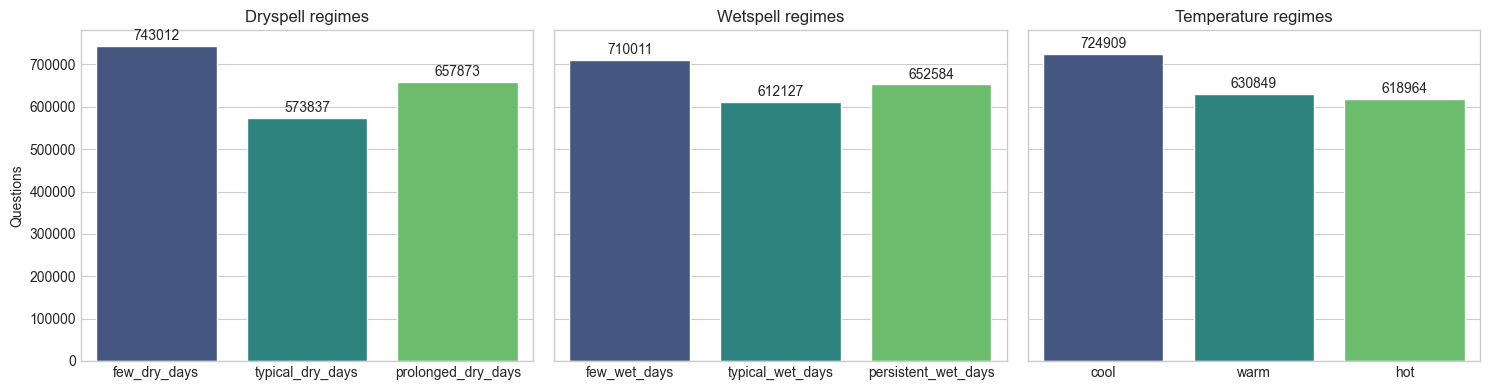

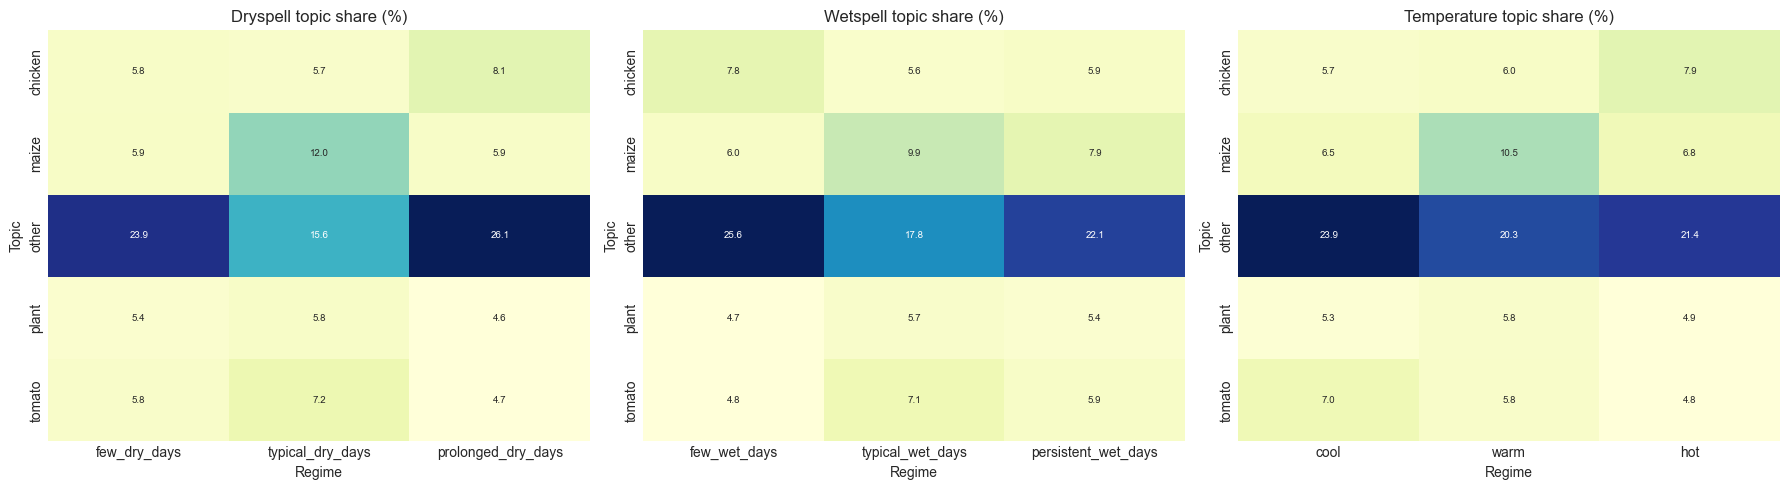

In [34]:
# 24.2a visualization
volume_map = {
    'Dryspell': dry_volume.rename(columns={'dryspell_regime': 'regime'}) if not dry_volume.empty else dry_volume,
    'Wetspell': wet_volume.rename(columns={'wetspell_regime': 'regime'}) if not wet_volume.empty else wet_volume,
    'Temperature': temp_volume.rename(columns={'temp_regime': 'regime'}) if not temp_volume.empty else temp_volume,
}
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, (title, df) in zip(axes, volume_map.items()):
    if df.empty:
        ax.set_title(f'{title}: no data')
        ax.axis('off')
        continue
    sns.barplot(
        data=df,
        x='regime',
        y='question_count',
        hue='regime',
        dodge=False,
        palette='viridis',
        legend=False,
        ax=ax,
    )
    ax.set_title(f'{title} regimes')
    ax.set_xlabel('')
    ax.set_ylabel('Questions' if ax is axes[0] else '')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', padding=2)
plt.tight_layout()
plt.show()

topic_sets = [
    ('Dryspell', dry_topics, 'dryspell_regime'),
    ('Wetspell', wet_topics, 'wetspell_regime'),
    ('Temperature', temp_topics, 'temp_regime'),
 ]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (title, df, regime_col) in zip(axes, topic_sets):
    if df.empty:
        ax.set_title(f'{title}: no topic data')
        ax.axis('off')
        continue
    pivot = df.pivot(index='question_topic', columns=regime_col, values='topic_share').fillna(0) * 100
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlGnBu', ax=ax, cbar=False, annot_kws={'fontsize': 7})
    ax.set_title(f'{title} topic share (%)')
    ax.set_xlabel('Regime')
    ax.set_ylabel('Topic')
plt.tight_layout()
plt.show()

### 24.3 Weather-only models for Uganda monthly topics
Compare logistic regression, random forest, and gradient boosting performance using only the national monthly CDD/CWD/TAS inputs.

In [35]:
# 24.3 Model comparison on Uganda monthly features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
weather_feature_cols = ['cdd_days', 'cwd_days', 'tas_celsius']
missing_weather_cols = [col for col in weather_feature_cols if col not in uganda_enriched.columns]
if missing_weather_cols:
    raise ValueError(f"Missing Uganda weather columns: {missing_weather_cols}")
uganda_ml = uganda_enriched.dropna(subset=weather_feature_cols + ['question_topic']).copy()
top_topics_ug = uganda_ml['question_topic'].value_counts().head(5).index.tolist()
uganda_ml = uganda_ml[uganda_ml['question_topic'].isin(top_topics_ug)].copy()
if len(uganda_ml) < 500:
    raise ValueError('Not enough Uganda records with weather merges to run the predictive comparison.')
X = uganda_ml[weather_feature_cols]
y = uganda_ml['question_topic']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
 )
baseline = y_test.value_counts(normalize=True).max()
models = {
    'LogisticRegression': Pipeline([
        ('scale', StandardScaler()),
        ('model', LogisticRegression(max_iter=2000, class_weight='balanced'))
    ]),
    'RandomForest': RandomForestClassifier(
        n_estimators=400, max_depth=14, random_state=42, n_jobs=-1, class_weight='balanced_subsample'
    ),
    'GradientBoosting': Pipeline([
        ('scale', StandardScaler()),
        ('model', GradientBoostingClassifier(random_state=42, subsample=0.85))
    ]),
}
comparison_rows = []
per_topic_scores = {}
for name, estimator in models.items():
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    comparison_rows.append({
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'macro_f1': f1_score(y_test, y_pred, average='macro'),
    })
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    per_topic_scores[name] = {label: stats['f1-score'] for label, stats in report.items() if label in top_topics_ug}
comparison_df = pd.DataFrame(comparison_rows).sort_values('accuracy', ascending=False)
print(f"Baseline (majority topic) accuracy: {baseline:.3f}")
display(comparison_df)
print('\nPer-topic F1 (Uganda monthly weather only):')
for name, metrics in per_topic_scores.items():
    formatted = ', '.join(f"{topic}: {score:.2f}" for topic, score in metrics.items())
    print(f"- {name}: {formatted if formatted else 'n/a'}")

C:\Users\POWER COMPUTER\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Baseline (majority topic) accuracy: 0.462


,model,accuracy,macro_f1
2,GradientBoosting,0.482378,0.235893
1,RandomForest,0.353837,0.303171
0,LogisticRegression,0.229224,0.215659



Per-topic F1 (Uganda monthly weather only):
- LogisticRegression: chicken: 0.23, maize: 0.27, other: 0.26, plant: 0.11, tomato: 0.21
- RandomForest: chicken: 0.24, maize: 0.36, other: 0.51, plant: 0.18, tomato: 0.23
- GradientBoosting: chicken: 0.04, maize: 0.32, other: 0.64, plant: 0.00, tomato: 0.17


### 25. Notebook summary & next steps

- **Data coverage & hygiene:** The event feed contains 20,304,843 question/response timestamps, but 5,447,943 rows are exact duplicates (2,978,928 would be dropped when keeping the first copy). Kenya, Uganda, and Tanzania account for 9.76â€¯M, 6.31â€¯M, and 4.23â€¯M user records respectively; English dominates language metadata (11.98â€¯M questions, 11.94â€¯M responses) followed by Swahili (~6.5â€¯M). Gender and date-of-birth fields are mostly blank (>19â€¯M NULLs), highlighting the limited demographic signal.
- **Topic mix & geography:** `question_topic` is missing for 3.54â€¯M rows, yet the remaining traffic is concentrated in maize (2.20â€¯M), cattle (1.68â€¯M), chicken (1.67â€¯M), tomato (1.10â€¯M), and poultry (1.05â€¯M). Country splits show Kenya skewed toward cattle/chicken, Uganda toward maize/tomato, and Tanzania toward maize/poultry, informing localized extension content.
- **Weather relationships (Kenya & Tanzania merges):** Dry and soaked weeks carry ~1.26â€¯M and ~1.35â€¯M questions, while cool/ hot temperature regimes carry 1.30â€¯M vs. 1.41â€¯M questions. Topic shares stay livestock-heavy, but precipitation deltas reach +2.94â€¯pp for chicken and +1.95â€¯pp for maize. Weather-only models lift accuracy from a 0.264 baseline to 0.333 (Gradient Boosting) with macro-F1 â‰ˆ0.266, and Random Forest balances precision/recall best (macro-F1 0.311).
- **Temporal forecasting experiment:** The weekly leader prototype performed worse than naive persistence (0.639 accuracy vs. a 0.705 majority baseline) because the small held-out period provides too few weeks per topic; richer features or longer histories are required before deploying leaderboards.
- **Uganda climate integration:** Monthly CDD/CWD/TAS tables contribute 888 national rows and map cleanly to all 6.31â€¯M Uganda questions (100â€¯% coverage). Regime volumes and topic shares (Section 24.2 visuals) show how farmer attention shifts between dryspell, wetspell, and temperature clusters, supplying the basis for agronomic narratives.
- **Uganda weather-only models:** Monthly Gradient Boosting now edges the 0.462 baseline with 0.482 accuracy (macro-F1 0.236), while Random Forest trades accuracy (0.354) for stronger minority performance (macro-F1 0.303, `other` topic F1 0.51). Logistic regression underperforms (0.229 accuracy). Adding farmer text, geography, and lagged climate shocks will be necessary to cross the 0.6+ accuracy bar.
- **Limitations & future work:** High duplicate rates, 3.5â€¯M unlabeled topics, and timezone warnings constrain reliability. Weather merges exist only for Kenya/Tanzania (daily) and Uganda (national monthly), omitting humidity, soil, and pest signals. Topic imbalance and sparse minority classes drive undefined precision in several models, and monthly Ugandan climate aggregates likely dilute local variability. Next iterations should (1) dedupe upstream, (2) backfill `question_topic` via NLP or clustering, (3) enrich weather with humidity/drought indices plus lag features, (4) combine farmer metadata/text into multimodal models, and (5) revisit the weekly forecast after resampling to more balanced time slices.